# Load packages

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

import seaborn

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from arch.unitroot import PhillipsPerron
from scipy import stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

import os

import pkg_resources

# Load all time series

## Example data

In [8]:
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/Example_graph') 

example = 'Example'

# Pick time range
start_year = 1950
length = 12*(2022 - start_year)

example_data = np.vstack((
    np.loadtxt('iera5_slp_-100--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_slp_130-150E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_u10m_-210--100E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
                )).T
T, N = example_data.shape

print(example_data)

[[ 1.011566e+05  1.007654e+05 -4.953936e+00]
 [ 1.011515e+05  1.007447e+05 -5.246562e+00]
 [ 1.011662e+05  1.008298e+05 -4.606627e+00]
 ...
 [ 1.012918e+05  1.009609e+05 -4.877577e+00]
 [ 1.013058e+05  1.008551e+05 -5.620036e+00]
 [ 1.012338e+05  1.008284e+05 -5.208512e+00]]


# Example 2 data

In [10]:
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/Example_graph') 

example2 = 'Example'

# Pick time range
start_year = 1950
length = 12*(2022 - start_year)

example2_data = np.vstack((
    np.loadtxt('iera5_ssr_-240--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_slp_-100--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_slp_130-150E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_u10m_-210--100E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
                )).T
T, N = example2_data.shape

## Reanalysis

In [11]:
os.chdir('/Users/esz320/Documents/Thesis to paper/Data') 

reanalysis = 'Reanalysis'

# Pick time range
start_year = 1950
length = 12*(2022 - start_year)

reanalysis_data = np.vstack((
    np.loadtxt('iera5_slp_130-150E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_t2m_-150--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_t2m_-100--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
                )).T
T, N = reanalysis_data.shape


print(len(reanalysis_data)/12)

nino34reanalysis = np.loadtxt('iera5_t2m_-170--120E_-5-5N_n.dat.txt', skiprows=20)[:, :]
nino34reanalysis = nino34reanalysis[:-1]
print(len(nino34reanalysis))


72.0
73


In [12]:
reanalysis_extended = 'Reanalysis extended'

# extended_data = np.vstack((
#     np.loadtxt('iera5_slp_130-150E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
#     np.loadtxt('iera5_t2m_-150--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
#     np.loadtxt('iera5_t2m_-100--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
#     #np.loadtxt('iera5_u10m_-210--100E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
#     np.loadtxt('iera5_u10m_-180--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
#     np.loadtxt('iera5_trbflx_-210--100E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
#                 ))
# extended_data[3, :] *= -1
# extended_data = extended_data.T
# T, N = extended_data.shape

# print(len(extended_data)/12)

# print(extended_data[:,:1])

# test = extended_data[:,:3]
# print(test)

extended_data = np.vstack((
    np.loadtxt('iera5_slp_130-150E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_t2m_-150--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_t2m_-100--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    #np.loadtxt('iera5_u10m_-210--100E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_u10m_-180--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    #np.loadtxt('iera5_trbflx_-210--100E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_trbflx_-180--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    #np.loadtxt('iera5_lhf_-180--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
                ))
extended_data[3, :] *= -1
extended_data[4, :] *= -1/2

print(extended_data)

# last_two_mean = np.mean(extended_data[-2:, :], axis=0)
# extended_data = extended_data[:-2, :]
# extended_data[3, :] *= -1

# extended_data = np.vstack((extended_data, last_two_mean))

extended_data = extended_data.T


[[1.007654e+05 1.007447e+05 1.008298e+05 ... 1.009609e+05 1.008551e+05
  1.008284e+05]
 [2.977563e+02 2.978752e+02 2.985520e+02 ... 2.977851e+02 2.977210e+02
  2.978257e+02]
 [2.966236e+02 2.977186e+02 2.979710e+02 ... 2.954964e+02 2.954913e+02
  2.957404e+02]
 [6.193619e+00 6.642407e+00 5.747903e+00 ... 5.994689e+00 6.632870e+00
  6.947123e+00]
 [6.411725e+01 5.421315e+01 5.163650e+01 ... 6.706300e+01 7.639825e+01
  6.295330e+01]]


# MODEL DATA

In [13]:
# Pick time range
start_year = 1850
length = 12*(2022 - start_year)

## Model: EC Earth3

In [14]:
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/ECEarth3') 

ecearth = 'EC-Earth3'

ecearth_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_EC-Earth3_ssp585.0_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_EC-Earth3_ssp585.0_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_EC-Earth3_ssp585.0_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = ecearth_data.shape

# but skip first 100 years, so skip 12*100 = 1200 extra rows
ecearth_data = ecearth_data[1200:]

print(len(ecearth_data)/12)

nino34ecearth = np.loadtxt('icmip6_tas_mon_EC-Earth3_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]
nino34ecearth = nino34ecearth[100:173,:]

print(len(nino34ecearth))

72.0
73


## Model: CESM2

In [15]:
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/CESM2') 

CESM2 = 'CESM2'

CESM2_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_CESM2_ssp585.0_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = CESM2_data.shape

# but skip first 100 years, so skip 12*100 = 1200 extra rows
CESM2_data = CESM2_data[1200:]
print(len(CESM2_data)/12)

nino34CESM2 = np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]

nino34CESM2 = nino34CESM2[100:173,:]

print(len(nino34CESM2))

72.0
73


## Model: GFDL-ESM4

In [16]:
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/GFDL-ESM4') 

GFDL_ESM4 = 'GFDL_ESM4'

GFDL_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_GFDL-ESM4_ssp585.0_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_GFDL-ESM4_ssp585.0_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_GFDL-ESM4_ssp585.0_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = GFDL_data.shape

GFDL_data = GFDL_data[1200:]
print(len(GFDL_data)/12)

nino34GFDL = np.loadtxt('icmip6_tas_mon_GFDL-ESM4_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]
nino34GFDL = nino34GFDL[100:173,:]

print(len(nino34GFDL))

72.0
73


## Model: MIROC6

#### Import data of 10 runs for robustness check 

In [17]:
# MIROC6 DATA
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/MIROC6') 

MIROC6 = 'MIROC6'

MIROC6_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_MIROC6_ssp585.0_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.0_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.0_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = MIROC6_data.shape

MIROC6_data = MIROC6_data[1200:]

nino34MIROC6 = np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]
nino34MIROC6 = nino34MIROC6[100:173,:]

# CHECK 1
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/MIROC6/Check1') 

check1_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_MIROC6_ssp585.1_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.1_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.1_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = check1_data.shape

check1_data = check1_data[1200:]

nino34check1 = np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.1_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]
nino34check1 = nino34check1[100:173,:]

# CHECK 2
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/MIROC6/Check2') 

check2_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_MIROC6_ssp585.2_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.2_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.2_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = check2_data.shape

check2_data = check2_data[1200:]

nino34check2 = np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.2_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]
nino34check2 = nino34check2[100:173,:]

# CHECK 3
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/MIROC6/Check3') 

check3_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_MIROC6_ssp585.3_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.3_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.3_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = check3_data.shape

check3_data = check3_data[1200:]

nino34check3 = np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.3_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]
nino34check3 = nino34check3[100:173,:]

# CHECK 4
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/MIROC6/Check4') 

check4_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_MIROC6_ssp585.4_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.4_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.4_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = check4_data.shape

check4_data = check4_data[1200:]

nino34check4 = np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.4_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]
nino34check4 = nino34check4[100:173,:]

# CHECK 5
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/MIROC6/Check5') 

check5_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_MIROC6_ssp585.5_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.5_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.5_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = check5_data.shape

check5_data = check5_data[1200:]

nino34check5 = np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.5_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]
nino34check5 = nino34check5[100:173,:]

# CHECK 6
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/MIROC6/Check6') 

check6_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_MIROC6_ssp585.6_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.6_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.6_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = check6_data.shape

check6_data = check6_data[1200:]

nino34check6 = np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.6_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]
nino34check6 = nino34check6[100:173,:]

# CHECK 7
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/MIROC6/Check7') 

check7_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_MIROC6_ssp585.7_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.7_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.7_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = check7_data.shape

check7_data = check7_data[1200:]

nino34check7 = np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.7_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]
nino34check7 = nino34check7[100:173,:]

# CHECK 8
os.chdir('/Users/esz320/Documents/Thesis to paper/Data/MIROC6/Check8') 

check8_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_MIROC6_ssp585.8_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.8_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.8_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = check8_data.shape

check8_data = check8_data[1200:]

nino34check8 = np.loadtxt('icmip6_tas_mon_MIROC6_ssp585.8_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]
nino34check8 = nino34check8[100:173,:]



In [18]:
check1 = 'Check 1'
check2 = 'Check 2'
check3 = 'Check 3'
check4 = 'Check 4'
check5 = 'Check 5'
check6 = 'Check 6'
check7 = 'Check 7'
check8 = 'Check 8'

# Define functions

In [19]:
# function to detrend + deseazonalize data
def deTrend_deSeasonalize(data, show_plot = True):
    # step 1: seasonal component
    decomposition = seasonal_decompose(data, model='additive', period=12)
    data = data - decomposition.seasonal
    # step 2: Trend based on Gaussian kernel smoother
    smoothed = pp.smooth(np.copy(data), smooth_width=15 * 12, residuals=False)
    index = range(0, len(data))

    if show_plot == True:
        plt.plot(index, data)
        plt.plot(index,smoothed)
        plt.legend(['data', 'Smoothed trend'])
        plt.title("Deseasonalized data with smoothed trend")
        plt.show()

    else:
        result = data - smoothed
        return result

In [20]:
# function to detrend data
def deTrend(data):
    # Trend based on Gaussian kernel smoother
    smoothed = pp.smooth(np.copy(data), smooth_width=30 * 12, residuals=True)
    return smoothed

In [21]:
# function that makes El nino, La nina mask
# input data from correct years + 1 from the climate explorer
# set to False if we do NOT want to mask this value

def mask_maker(df_sstnino34):
    nino34list = df_sstnino34[:,1:].reshape(-1)

    nino34list = deTrend(nino34list)
    nino34list_by_year = nino34list.reshape(-1,12)

    # NINO MASK
    
    ninamask = np.ones(len(nino34list)).reshape(-1,12)
    ninomask = np.ones(len(nino34list)).reshape(-1,12)
    neutralmask = np.ones(len(nino34list)).reshape(-1,12)

    for i in range(len(nino34list_by_year)-1):
        if (nino34list_by_year[i,10] + nino34list_by_year[i,11] + nino34list_by_year[i+1,0])/3 > 0.5:
            ninomask[i,1:] = False
            ninomask[i+1,0] = False
    ninomask = ninomask[:len(ninomask),:].reshape(-1)
    ninomask = ninomask[:-12]
    
    for i in range(len(nino34list_by_year)-1):
        if (nino34list_by_year[i,10] + nino34list_by_year[i,11] + nino34list_by_year[i+1,0])/3 < -0.5:
            ninamask[i,1:] = False
            ninamask[i+1,0] = False
    ninamask = ninamask[:len(ninamask),:].reshape(-1)
    ninamask = ninamask[:-12]
    
    for i in range(len(nino34list_by_year)-1):
        if -0.5 < (nino34list_by_year[i,10] + nino34list_by_year[i,11] + nino34list_by_year[i+1,0])/3 < 0.5:
            neutralmask[i,1:] = False
            neutralmask[i+1,0] = False
    #neutralmask = neutralmask[:len(neutralmask)-1,:].reshape(-1)
    neutralmask = neutralmask[:len(neutralmask),:].reshape(-1)  
    neutralmask = neutralmask[:-12]
    
    return ninomask, ninamask, neutralmask

In [22]:
def compute_f1_score(pcmci_result_referencemodel, pcmci_result_othermodel, threshold):
    reference = np.where(pcmci_result_referencemodel['p_matrix'].round(3) < threshold, 1, 0)
    other = np.where(pcmci_result_othermodel['p_matrix'].round(3) < threshold, 1, 0)
    other_flat = other.flatten()
    reference_flat = reference.flatten()
    f1 = f1_score(reference_flat, other_flat)
    return f1

In [23]:
def count_enso(mask,year):
    count = 0
    for i in range(len(mask)-year*12, len(mask), 12):
        if mask[i+3] == 0:
            count+=1
            
    return count

In [24]:
def compute_mean_correlations(p_matrices, val_matrices):
    num_matrices = p_matrices.shape[0]
    sum_significant_values = 0
    count_significant_values = 0

    for i in range(num_matrices):
        p_matrix = p_matrices[i]
        val_matrix = val_matrices[i]
    
        rows = p_matrices[i].shape[0]
        columns = p_matrices[i].shape[1]
        # Skip the first column in each matrix
    
        for j in range(rows):
            for k in range(1, columns):
                if p_matrix[j,k] < 0.05:
                    sum_significant_values += abs(val_matrix[j,k])
                    count_significant_values += 1
    
        if count_significant_values > 0:
            mean_significant_values = sum_significant_values / count_significant_values
        else:
            mean_significant_values = 0

    return mean_significant_values, count_significant_values

In [25]:
# define parcorr
parcorr = ParCorr(significance='analytic', mask_type='y')

## Function to test robustness of masked data

In [26]:
def mainfunction(GFDL_data, nino34data, print_name, parcorr, info = True, extended = False, example = False):
    
    if extended == True:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'ZWS', 'NHF']

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['ZWS'], show_plot = False)
        nhf_detrend = deTrend_deSeasonalize(df_GFDL['NHF'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'ZWS': zws_detrend,
                                        'NHF': nhf_detrend})
    
    elif extended == False and example == False:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC']

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)

        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 'CPAC': cpac_detrend_GFDL, 'EPAC': epac_detrend_GFDL})
    
    elif example == True:
        # Variable names used throughout
        var_names = ['SLPE', 'SLPW', 'ZWS']

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['SLPW'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['ZWS'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['SLPE'], show_plot = False)

        df_GFDL_processed = pd.DataFrame({'SLPE': wpac_detrend_GFDL, 'SLPW': cpac_detrend_GFDL, 'ZWS': epac_detrend_GFDL})
        
        parcorr = ParCorr(significance='analytic')
                
        dataframe_GFDL = pp.DataFrame(np.copy(df_GFDL_processed), datatime = {0:np.arange(len(df_GFDL_processed))}, var_names= var_names)
        pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=8)
        results_springbarrier = pcmci_GFDL.run_pcmci(tau_max=1, tau_min=1, pc_alpha=0.01, alpha_level=0.01, fdr_method = 'fdr_bh')
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

        tp.plot_graph(
            val_matrix=results_springbarrier['val_matrix'],
            graph=results_springbarrier['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0]))
        axes[0].set_title('Example graph')
        
        tp.plot_time_series_graph(
            val_matrix=results_springbarrier['val_matrix'],
            graph=results_springbarrier['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            fig_ax= (fig, axes[1]))
        axes[1].set_title('Example time series graph')
        
        plt.show()
        
        return results_springbarrier

        
    ninomask_GFDL, ninamask_GFDL, neutralmask_GFDL = mask_maker(nino34data)
    
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(df_GFDL_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(df_GFDL_processed), datatime = {0:np.arange(len(df_GFDL_processed))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_springbarrier = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

    # Construct mask for spring barrier
    cycle_length = 12
    nina_spring_GFDL = np.ones(df_GFDL_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        nina_spring_GFDL[i::cycle_length, :] = False
    
    # Additionally mask to pick only La Nina phases in spring barrier
    for t in range(nina_spring_GFDL.shape[0]):
        if ninamask_GFDL[t] == True:
            nina_spring_GFDL[t] = True
        
    dataframe_GFDL = pp.DataFrame(np.copy(df_GFDL_processed), datatime = {0:np.arange(len(df_GFDL_processed))}, var_names= var_names, mask = nina_spring_GFDL)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_nina = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
    # Construct mask for spring barrier
    cycle_length = 12
    nino_spring_GFDL = np.ones(df_GFDL_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        nino_spring_GFDL[i::cycle_length, :] = False
    
    # Additionally mask to pick only El Nino years 
    for t in range(nino_spring_GFDL.shape[0]):
        if ninomask_GFDL[t] == True:
            nino_spring_GFDL[t] = True
        
    dataframe_GFDL = pp.DataFrame(np.copy(df_GFDL_processed), datatime = {0:np.arange(len(df_GFDL_processed))}, var_names= var_names, mask = nino_spring_GFDL)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_nino = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

    if info == True:
        
        # print the generating process of the data
        print(f'{print_name} results')
        
        print('p-value PhillipsPerron test cpac:', PhillipsPerron(cpac_detrend_GFDL).pvalue)
        print('p-value PhillipsPerron test epac:', PhillipsPerron(epac_detrend_GFDL).pvalue)
        print('p-value PhillipsPerron test wpac:', PhillipsPerron(wpac_detrend_GFDL).pvalue)
        
        print('p-value Shapiro-Wilk test cpac:', stats.shapiro(cpac_detrend_GFDL).pvalue)
        print('p-value Shapiro-Wilk test epac:', stats.shapiro(epac_detrend_GFDL).pvalue)
        print('p-value Shapiro-Wilk test wpac:', stats.shapiro(wpac_detrend_GFDL).pvalue)
        
        print(f'Number of nino years {print_name}: ', count_enso(ninomask_GFDL, round(len(ninomask_GFDL)/12)))
        print(f'Number of nina years {print_name}: ', count_enso(ninamask_GFDL, round(len(ninamask_GFDL)/12)))
        print(f'Number of neutral years {print_name}: ', count_enso(neutralmask_GFDL, round(len(neutralmask_GFDL)/12)))
        
        ## PLOT ALL DAGS

        fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

        tp.plot_graph(
            val_matrix=results_springbarrier['val_matrix'],
            graph=results_springbarrier['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0]))
        axes[0].set_title('Spring barrier')

        tp.plot_graph(
            val_matrix=results_nina['val_matrix'],
            graph=results_nina['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1]))
        axes[1].set_title('Spring barrier towards La Niña')

        tp.plot_graph(
            val_matrix=results_nino['val_matrix'],
            graph=results_nino['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[2]))
        axes[2].set_title('Spring barrier towards El Niño')

        fig.suptitle(f'Causal networks based on {print_name} model data', fontsize = 18)
    
        plt.subplots_adjust(hspace=0.8)
        plt.show()
        
        return results_springbarrier, results_nina, results_nino

    else:
        return results_springbarrier, results_nina, results_nino
    
    

In [27]:
# # function that only takes spring barrier mask

# def link_robustness(GFDL_data, nino34data, print_name, parcorr, extended = 0):
    
#     if extended == 0:
#         GFDL_data = [arr[:3] for arr in GFDL_data]
#         # Variable names used throughout
#         var_names = ['WPAC', 'CPAC', 'EPAC']

#         # make data frame of data
#         df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
#         dataframe_GFDL = pp.DataFrame(GFDL_data, 
#                                  datatime = np.arange(len(GFDL_data)), 
#                                  var_names=var_names)

#         cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
#         epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
#         wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)

#         df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 'CPAC': cpac_detrend_GFDL, 'EPAC': epac_detrend_GFDL})
    
#     elif extended == 1:
#         GFDL_data = [arr[:4] for arr in GFDL_data]
#         # Variable names used throughout
#         var_names = ['WPAC', 'CPAC', 'EPAC', 'ZWS']

#         # make data frame of data
#         df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
#         dataframe_GFDL = pp.DataFrame(GFDL_data, 
#                                  datatime = np.arange(len(GFDL_data)), 
#                                  var_names=var_names)

#         cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
#         epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
#         wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
#         zws_detrend = deTrend_deSeasonalize(df_GFDL['ZWS'], show_plot = False)
        
#         df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
#                                         'CPAC': cpac_detrend_GFDL, 
#                                         'EPAC': epac_detrend_GFDL,
#                                         'ZWS': zws_detrend})
    
#     elif extended == 2:
#         # Variable names used throughout
#         var_names = ['WPAC', 'CPAC', 'EPAC', 'ZWS', 'NHF']

#         # make data frame of data
#         df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
#         dataframe_GFDL = pp.DataFrame(GFDL_data, 
#                                  datatime = np.arange(len(GFDL_data)), 
#                                  var_names=var_names)

#         cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
#         epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
#         wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
#         zws_detrend = deTrend_deSeasonalize(df_GFDL['ZWS'], show_plot = False)
#         nhf_detrend = deTrend_deSeasonalize(df_GFDL['NHF'], show_plot = False)
        
#         df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
#                                         'CPAC': cpac_detrend_GFDL, 
#                                         'EPAC': epac_detrend_GFDL,
#                                         'ZWS': zws_detrend,
#                                         'NHF': nhf_detrend})
    
#     test1 = df_GFDL_processed
#     test2 = df_GFDL_processed[:-24]
#     test3 = df_GFDL_processed[:-96]
#     test4 = df_GFDL_processed[96:]
    
#     # Construct mask for spring barrier
#     cycle_length = 12
#     springbarrier_mask = np.ones(test1.shape, dtype=bool)
#     for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
#         springbarrier_mask[i::cycle_length, :] = False
    
#     dataframe_GFDL = pp.DataFrame(np.copy(test1), datatime = {0:np.arange(len(test1))}, var_names= var_names, mask = springbarrier_mask)
#     pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
#     results_test1 = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

#         # Construct mask for spring barrier
#     cycle_length = 12
#     springbarrier_mask = np.ones(test2.shape, dtype=bool)
#     for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
#         springbarrier_mask[i::cycle_length, :] = False
    
#     dataframe_GFDL = pp.DataFrame(np.copy(test2), datatime = {0:np.arange(len(test2))}, var_names= var_names, mask = springbarrier_mask)
#     pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
#     results_test2 = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

#         # Construct mask for spring barrier
#     cycle_length = 12
#     springbarrier_mask = np.ones(test3.shape, dtype=bool)
#     for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
#         springbarrier_mask[i::cycle_length, :] = False
    
#     dataframe_GFDL = pp.DataFrame(np.copy(test3), datatime = {0:np.arange(len(test3))}, var_names= var_names, mask = springbarrier_mask)
#     pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
#     results_test3 = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

#         # Construct mask for spring barrier
#     cycle_length = 12
#     springbarrier_mask = np.ones(test4.shape, dtype=bool)
#     for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
#         springbarrier_mask[i::cycle_length, :] = False
    
#     dataframe_GFDL = pp.DataFrame(np.copy(test4), datatime = {0:np.arange(len(test4))}, var_names= var_names, mask = springbarrier_mask)
#     pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
#     results_test4 = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

    
#     if info == True:
#         ## PLOT ALL DAGS

#         fig, axes = plt.subplots(2, 4, figsize=(12, 4), tight_layout=True)

#         tp.plot_graph(
#             val_matrix=results_test1['val_matrix'],
#             graph=results_test1['graph'],
#             var_names=var_names,
#             link_colorbar_label='cross-MCI',
#             node_colorbar_label='auto-MCI',
#             fig_ax= (fig, axes[0,0]))
#         axes[0,0].set_title('1950-2022')

#         tp.plot_graph(
#             val_matrix=results_test2['val_matrix'],
#             graph=results_test2['graph'],
#             var_names=var_names,
#             link_colorbar_label='cross-MCI',
#             node_colorbar_label='auto-MCI',
#             fig_ax= (fig, axes[0,1]))
#         axes[0,1].set_title('1950-2020')

#         tp.plot_graph(
#             val_matrix=results_test3['val_matrix'],
#             graph=results_test3['graph'],
#             var_names=var_names,
#             link_colorbar_label='cross-MCI',
#             node_colorbar_label='auto-MCI',
#             fig_ax= (fig, axes[1,0]))
#         axes[2].set_title('1950-2014')
        
#         tp.plot_graph(
#             val_matrix=results_test4['val_matrix'],
#             graph=results_test4['graph'],
#             var_names=var_names,
#             link_colorbar_label='cross-MCI',
#             node_colorbar_label='auto-MCI',
#             fig_ax= (fig, axes[1,1]))
#         axes[1,1].set_title('1958-2022')

#         fig.suptitle(f'Causal networks based on reanalysis data of different years', fontsize = 18)
    
#         plt.subplots_adjust(hspace=0.8)
#         plt.show()
        
#         return results_test1, results_test2, results_test3, results_test4
    
    

# Function to compare 1950-1985 with 1986-2020

In [28]:
def firsthalf_lasthalf(GFDL_data, nino34data, print_name, parcorr, extended = False):
    
    # delete years 2021, 2022
    GFDL_data = GFDL_data[:-96]
    nino34data = nino34data[:-8]
    
    if extended == True:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'ZWS', 'NHF']

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['ZWS'], show_plot = False)
        nhf_detrend = deTrend_deSeasonalize(df_GFDL['NHF'], show_plot = False)
        
        #df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
        #                                'CPAC': cpac_detrend_GFDL, 
        #                                'EPAC': epac_detrend_GFDL,
        #                                'ZWS': zws_detrend,
        #                                'NHF': nhf_detrend})
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'ZWS': zws_detrend})
    
    else:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC']

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)

        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 'CPAC': cpac_detrend_GFDL, 'EPAC': epac_detrend_GFDL})
    
    half = int(len(df_GFDL_processed)/2)
    df_firsthalf = df_GFDL_processed[:half]
    df_secondhalf = df_GFDL_processed[half:]

    ninomask_GFDL, ninamask_GFDL, neutralmask_GFDL = mask_maker(nino34data)
    
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(df_GFDL_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(df_firsthalf), datatime = {0:np.arange(len(df_firsthalf))}, var_names= var_names, mask = springbarrier_mask[:half,:])
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_springbarrier_firsthalf = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
    dataframe_GFDL = pp.DataFrame(np.copy(df_secondhalf), datatime = {0:np.arange(len(df_secondhalf))}, var_names= var_names, mask = springbarrier_mask[half:,:])
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_springbarrier_secondhalf = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
    # Construct mask for spring barrier
    cycle_length = 12
    nina_spring_GFDL = np.ones(df_GFDL_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        nina_spring_GFDL[i::cycle_length, :] = False
    
    # Additionally mask to pick only La Nina phases in spring barrier
    for t in range(nina_spring_GFDL.shape[0]):
        if ninamask_GFDL[t] == True:
            nina_spring_GFDL[t] = True
        
    dataframe_GFDL = pp.DataFrame(np.copy(df_firsthalf), datatime = {0:np.arange(len(df_firsthalf))}, var_names= var_names, mask = nina_spring_GFDL[:half,:])
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_nina_firsthalf = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
    dataframe_GFDL = pp.DataFrame(np.copy(df_secondhalf), datatime = {0:np.arange(len(df_secondhalf))}, var_names= var_names, mask = nina_spring_GFDL[half:,:])
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_nina_secondhalf = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
    # Construct mask for spring barrier
    cycle_length = 12
    nino_spring_GFDL = np.ones(df_GFDL_processed.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        nino_spring_GFDL[i::cycle_length, :] = False
    
    # Additionally mask to pick only El Nino years 
    for t in range(nino_spring_GFDL.shape[0]):
        if ninomask_GFDL[t] == True:
            nino_spring_GFDL[t] = True
        
    dataframe_GFDL = pp.DataFrame(np.copy(df_firsthalf), datatime = {0:np.arange(len(df_firsthalf))}, var_names= var_names, mask = nino_spring_GFDL[:half,:])
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_nino_firsthalf = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
    dataframe_GFDL = pp.DataFrame(np.copy(df_secondhalf), datatime = {0:np.arange(len(df_secondhalf))}, var_names= var_names, mask = nino_spring_GFDL[half:,:])
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_nino_secondhalf = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

    fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

    tp.plot_graph(
        val_matrix=results_springbarrier_firsthalf['val_matrix'],
        graph=results_springbarrier_firsthalf['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        fig_ax= (fig, axes[0]))
    axes[0].set_title(f'{print_name} data 1950-1982')

    tp.plot_graph(
        val_matrix=results_springbarrier_secondhalf['val_matrix'],
        graph=results_nina_firsthalf['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        fig_ax= (fig, axes[1]))
    axes[1].set_title(f'{print_name} data 1983-2014')
    ## PLOT ALL DAGS
    
    plt.show()
    
#     fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

#     tp.plot_graph(
#         val_matrix=results_springbarrier_firsthalf['val_matrix'],
#         graph=results_springbarrier_firsthalf['graph'],
#         var_names=var_names,
#         link_colorbar_label='cross-MCI',
#         node_colorbar_label='auto-MCI',
#         fig_ax= (fig, axes[0]))
#     axes[0].set_title('Spring barrier')

#     tp.plot_graph(
#         val_matrix=results_nina_firsthalf['val_matrix'],
#         graph=results_nina_firsthalf['graph'],
#         var_names=var_names,
#         link_colorbar_label='cross-MCI',
#         node_colorbar_label='auto-MCI',
#         fig_ax= (fig, axes[1]))
#     axes[1].set_title('Spring barrier towards La Niña')

#     tp.plot_graph(
#         val_matrix=results_nino_firsthalf['val_matrix'],
#         graph=results_nino_firsthalf['graph'],
#         var_names=var_names,
#         link_colorbar_label='cross-MCI',
#         node_colorbar_label='auto-MCI',
#         fig_ax= (fig, axes[2]))
#     axes[2].set_title('Spring barrier towards El Niño')

#     fig.suptitle(f'Causal networks based on {print_name} model data 1950-1985', fontsize = 18)
    
#     plt.subplots_adjust(hspace=0.8)
#     plt.show()
    
    print(f'Number of nino years before 1985: ', count_enso(ninomask_GFDL[half:], round(len(ninomask_GFDL[half:])/12)))
    print(f'Number of nina years before 1985: ', count_enso(ninamask_GFDL[half:], round(len(ninamask_GFDL[half:])/12)))
    print(f'Number of neutral years before 1985: ', count_enso(neutralmask_GFDL[half:], round(len(neutralmask_GFDL[half:])/12)))
    
    mean_first, links_first = compute_mean_correlations(results_springbarrier_firsthalf['p_matrix'], results_springbarrier_firsthalf['val_matrix'])
    
    print(f'Number of significant links based on data before 1985: {links_first}')
    print(f'Mean strength of significant links based on data before 1985: {mean_first}')
    
#     ## PLOT ALL DAGS
    
#     ## PLOT ALL DAGS

#     fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

#     tp.plot_graph(
#         val_matrix=results_springbarrier_secondhalf['val_matrix'],
#         graph=results_springbarrier_secondhalf['graph'],
#         var_names=var_names,
#         link_colorbar_label='cross-MCI',
#         node_colorbar_label='auto-MCI',
#         fig_ax= (fig, axes[0]))
#     axes[0].set_title('Spring barrier')

#     tp.plot_graph(
#         val_matrix=results_nina_secondhalf['val_matrix'],
#         graph=results_nina_secondhalf['graph'],
#         var_names=var_names,
#         link_colorbar_label='cross-MCI',
#         node_colorbar_label='auto-MCI',
#         fig_ax= (fig, axes[1]))
#     axes[1].set_title('Spring barrier towards La Niña')

#     tp.plot_graph(
#         val_matrix=results_nino_secondhalf['val_matrix'],
#         graph=results_nino_secondhalf['graph'],
#         var_names=var_names,
#         link_colorbar_label='cross-MCI',
#         node_colorbar_label='auto-MCI',
#         fig_ax= (fig, axes[2]))
#     axes[2].set_title('Spring barrier towards El Niño')

#     fig.suptitle(f'Causal networks based on {print_name} model data 1986-2020', fontsize = 18)
    
#     plt.subplots_adjust(hspace=0.8)
#     plt.show()
 
    
    print(f'Number of nino years after 1985: ', count_enso(ninomask_GFDL[:half], round(len(ninomask_GFDL[:half])/12)))
    print(f'Number of nina years after 1985: ', count_enso(ninamask_GFDL[:half], round(len(ninamask_GFDL[:half])/12)))
    print(f'Number of neutral years after 1985: ', count_enso(neutralmask_GFDL[:half], round(len(neutralmask_GFDL[:half])/12)))
    
    mean_second, links_second = compute_mean_correlations(results_springbarrier_secondhalf['p_matrix'], results_springbarrier_secondhalf['val_matrix'])
    
    print(f'Number of significant links based on data after 1985: {links_second}')
    print(f'Mean strength of significant links based on data after 1985: {mean_second}')
    
    return results_springbarrier_firsthalf, results_springbarrier_secondhalf
    

In [29]:
def score_function(print_name,
                  results_springbarrier_reference,
                  results_nina_reference, 
                  results_nino_reference,
                  results_springbarrier_model,
                  results_nina_model,
                  results_nino_model, plot = True
                  ):
    score_springbarrier_model = compute_f1_score(results_springbarrier_reference, results_springbarrier_model, 0.05)
    score_nina_model = compute_f1_score(results_nina_reference, results_nina_model, 0.05)
    score_nino_model = compute_f1_score(results_nino_reference, results_nino_model, 0.05)

    if plot == True:
        print(f'F1 score springbarrier model {print_name}: ', score_springbarrier_model)
        print(f'F1 score nina model {print_name}: ', score_nina_model)
        print(f'F1 score nino model {print_name}: ', score_nino_model)
    else:
        return score_springbarrier_model, score_nina_model, score_nino_model

# Robustness check

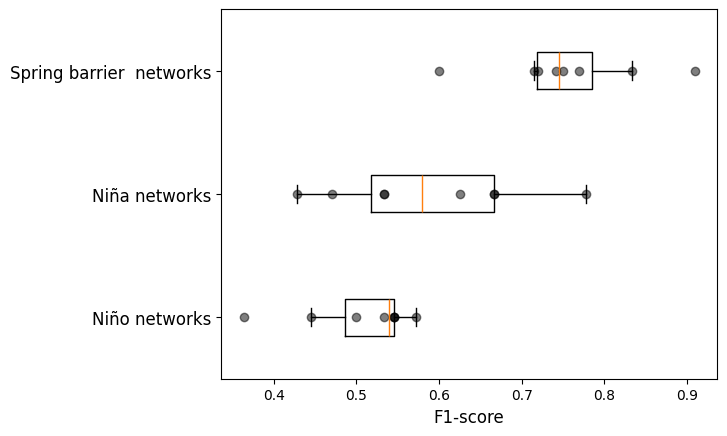

In [30]:
results_springbarrier_MIROC6, results_nina_MIROC6, results_nino_MIROC6 = mainfunction(MIROC6_data, nino34MIROC6, MIROC6, parcorr, info = False)

results_springbarrier_check1, results_nina_check1, results_nino_check1 = mainfunction(check1_data, nino34check1, check1, parcorr, info = False)
score_check1 = score_function(check1,
                  results_springbarrier_MIROC6,
                  results_nina_MIROC6, 
                  results_nino_MIROC6,
                  results_springbarrier_check1,
                  results_nina_check1,
                  results_nino_check1, plot = False
                  )

results_springbarrier_check8, results_nina_check8, results_nino_check8 = mainfunction(check8_data, nino34check8, check8, parcorr, info = False)
score_check8 = score_function(check8,
                  results_springbarrier_MIROC6,
                  results_nina_MIROC6, 
                  results_nino_MIROC6,
                  results_springbarrier_check8,
                  results_nina_check8,
                  results_nino_check8, plot = False
                  )

results_springbarrier_check2, results_nina_check2, results_nino_check2 = mainfunction(check2_data, nino34check2, check2, parcorr, info = False)
score_check2 = score_function(check2,
                  results_springbarrier_MIROC6,
                  results_nina_MIROC6, 
                  results_nino_MIROC6,
                  results_springbarrier_check2,
                  results_nina_check2,
                  results_nino_check2, plot = False
                  )

results_springbarrier_check3, results_nina_check3, results_nino_check3 = mainfunction(check3_data, nino34check3, check3, parcorr, info = False)
score_check3 = score_function(check3,
                  results_springbarrier_MIROC6,
                  results_nina_MIROC6, 
                  results_nino_MIROC6,
                  results_springbarrier_check3,
                  results_nina_check3,
                  results_nino_check3, plot = False
                  )

results_springbarrier_check4, results_nina_check4, results_nino_check4 = mainfunction(check4_data, nino34check4, check4, parcorr, info = False)
score_check4 = score_function(check4,
                  results_springbarrier_MIROC6,
                  results_nina_MIROC6, 
                  results_nino_MIROC6,
                  results_springbarrier_check4,
                  results_nina_check4,
                  results_nino_check4, plot = False
                  )

results_springbarrier_check5, results_nina_check5, results_nino_check5 = mainfunction(check5_data, nino34check5, check5, parcorr, info = False)
score_check5 = score_function(check5,
                  results_springbarrier_MIROC6,
                  results_nina_MIROC6, 
                  results_nino_MIROC6,
                  results_springbarrier_check5,
                  results_nina_check5,
                  results_nino_check5, plot = False
                  )

results_springbarrier_check6, results_nina_check6, results_nino_check6 = mainfunction(check6_data, nino34check6, check6, parcorr, info = False)
score_check6 = score_function(check6,
                  results_springbarrier_MIROC6,
                  results_nina_MIROC6, 
                  results_nino_MIROC6,
                  results_springbarrier_check6,
                  results_nina_check6,
                  results_nino_check6, plot = False
                  )

results_springbarrier_check7, results_nina_check7, results_nino_check7 = mainfunction(check7_data, nino34check7, check7, parcorr, info = False)
score_check7 = score_function(check7,
                  results_springbarrier_MIROC6,
                  results_nina_MIROC6, 
                  results_nino_MIROC6,
                  results_springbarrier_check7,
                  results_nina_check7,
                  results_nino_check7, plot = False
                  )

check_springbarrier = [score_check1[0],
                      score_check2[0],
                      score_check3[0],
                      score_check4[0],
                      score_check5[0],
                      score_check6[0],
                      score_check7[0],
                      score_check8[0]]

check_nina = [score_check1[1],
                      score_check2[1],
                      score_check3[1],
                      score_check4[1],
                      score_check5[1],
                      score_check6[1],
                      score_check7[1],
                      score_check8[1]]

check_nino = [score_check1[2],
                      score_check2[2],
                      score_check3[2],
                      score_check4[2],
                      score_check5[2],
                      score_check6[2],
                      score_check7[2],
                      score_check8[2]]


# Create figure and axis
fig, ax = plt.subplots()

# Data for boxplots
data = [check_nino, check_nina, check_springbarrier]

# Creating the boxplot with all points
ax.boxplot(data, vert=False, showfliers=False)

# Plotting all individual points
for i, d in enumerate(data, start=1):
    x = d
    y = [i] * len(d)
    ax.plot(x, y, 'ko', alpha=0.5)

# Customize labels
ax.set_yticklabels(['Niño networks', 'Niña networks', 'Spring barrier  networks'], fontsize = 12)

# Set title and labels
ax.set_title('', fontsize = 16)
ax.set_xlabel('F1-score', fontsize = 12)
ax.set_ylabel('')

# Show the plot
#plt.savefig('/Users/hp/Documents/Econometrics; Climate Economics/Scriptie/Figures/robustnes_check_F1_scores.png', fontsize = 22)
plt.show()



# Robustness check on the links

In [31]:
# function that only takes spring barrier mask

def link_robustness(GFDL_data, parcorr, extended = 0, info = True):
    parcorr = ParCorr(confidence='analytic', mask_type='y')
    if extended == 0:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC']
        GFDL_data = GFDL_data[:,:3]

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)

        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 'CPAC': cpac_detrend_GFDL, 'EPAC': epac_detrend_GFDL})
    
    elif extended == 1:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']
        GFDL_data = GFDL_data[:,:4]

        
        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend})
        
        #df_GFDL_processed['ZWS'] = df_GFDL_processed['ZWS']*-1
    
    elif extended == 2:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        nhf_detrend = deTrend_deSeasonalize(df_GFDL['NHF'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend,
                                        'NHF': nhf_detrend})
        
        #df_GFDL_processed['ZWS'] = df_GFDL_processed['ZWS']*-1
    
    # 1950-1985
    test1vroeg = df_GFDL_processed[:420]
    # 1950-1980
    test2vroeg = df_GFDL_processed[:360]
    #1951-1983
    test3vroeg = df_GFDL_processed[12:396]
    #1950-1982
    test4vroeg = df_GFDL_processed[:384]
    # 1986-2020
    test1laat = df_GFDL_processed[420:840]
    # 1980-2010
    test2laat = df_GFDL_processed[360:-144]
    #1984-2016
    test3laat = df_GFDL_processed[396:-60]
    #1983-2014
    test4laat = df_GFDL_processed[385:-96]
    
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test1vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test1vroeg), datatime = {0:np.arange(len(test1vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test1vroeg = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.01, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test2vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test2vroeg), datatime = {0:np.arange(len(test2vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test2vroeg = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test3vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test3vroeg), datatime = {0:np.arange(len(test3vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test3vroeg = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test4vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test4vroeg), datatime = {0:np.arange(len(test4vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test4vroeg = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test1laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test1laat), datatime = {0:np.arange(len(test1laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test1laat = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test2laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test2laat), datatime = {0:np.arange(len(test2laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test2laat = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test3laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test3laat), datatime = {0:np.arange(len(test3laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test3laat = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test4laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test4laat), datatime = {0:np.arange(len(test4laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test4laat = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
    if info == True:
        ## PLOT ALL DAGS

        fig, axes = plt.subplots(4, 2, figsize=(8, 16), tight_layout=True)

        tp.plot_graph(
            val_matrix=results_test1vroeg['val_matrix'],
            graph=results_test1vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0,0]))
        axes[0,0].set_title('1950-1985')

        tp.plot_graph(
            val_matrix=results_test1laat['val_matrix'],
            graph=results_test1laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0,1]))
        axes[0,1].set_title('1986-2020')

        tp.plot_graph(
            val_matrix=results_test2vroeg['val_matrix'],
            graph=results_test2vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1,0]))
        axes[1,0].set_title('1950-1980')
        
        tp.plot_graph(
            val_matrix=results_test2laat['val_matrix'],
            graph=results_test2laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1,1]))
        axes[1,1].set_title('1980-2010')
        
        tp.plot_graph(
            val_matrix=results_test3vroeg['val_matrix'],
            graph=results_test3vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[2,0]))
        axes[2,0].set_title('1951-1983')
        
        tp.plot_graph(
            val_matrix=results_test3laat['val_matrix'],
            graph=results_test3laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[2,1]))
        axes[2,1].set_title('1984-2016')
        
        tp.plot_graph(
            val_matrix=results_test4vroeg['val_matrix'],
            graph=results_test4vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[3,0]))
        axes[3,0].set_title('1950-1981')

        tp.plot_graph(
            val_matrix=results_test4laat['val_matrix'],
            graph=results_test4laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[3,1]))
        axes[3,1].set_title('1982-2014')

        fig.suptitle(f'Causal networks based on reanalysis data', fontsize = 18)
    
        plt.subplots_adjust(hspace=0.8)
        plt.show()

        return results_test1vroeg, results_test2vroeg, results_test3vroeg, results_test4vroeg, results_test1laat, results_test2laat, results_test3laat, results_test4laat
    
    

# Robustness tests of the links of reanalysis data

## Three node network

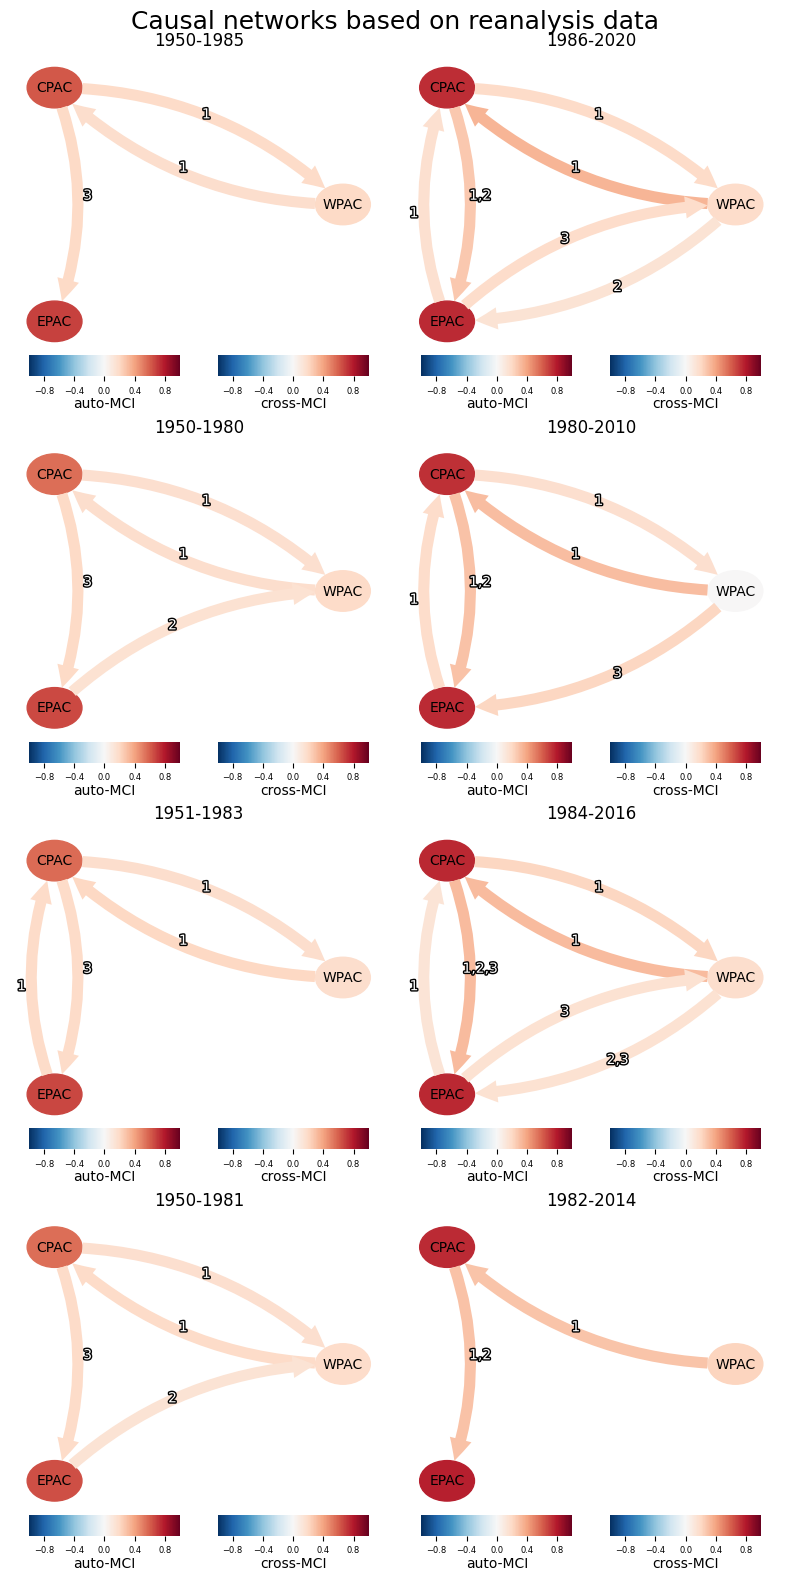

In [32]:
test0_1vroeg, test0_2vroeg, test0_3vroeg, test0_4vroeg, test0_1laat, test0_2laat, test0_3laat, test0_4laat  = link_robustness(extended_data, parcorr, extended = 0)

In [33]:
# print(test0_4vroeg['val_matrix'])
# print(test0_4vroeg['conf_matrix'])
# print(test0_4laat['val_matrix'])

### Adjust graphs to 'robust' graphs

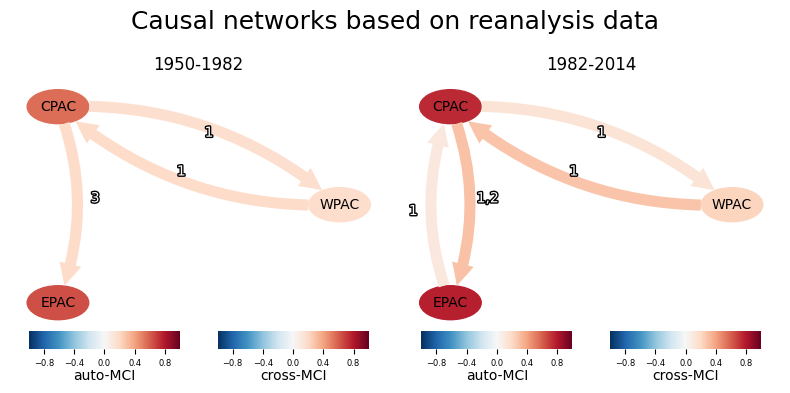

In [35]:
var_names = ['WPAC', 'CPAC', 'EPAC']
graph_vroeg_threenode = np.array([[['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '', '', '']],

       [['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '', '', '-->']],

       [['', '', '', ''],
        ['', '', '', ''],
        ['', '-->', '-->', '']]], dtype='<U3')

graph_laat_threenode = np.array([[['', '', '-->', ''],
        ['', '-->', '', ''],
        ['', '', '', '']],

       [['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '-->', '']],

       [['', '', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '', '']]], dtype='<U3')


fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
tp.plot_graph(
            val_matrix=test0_4vroeg['val_matrix'],
            graph=graph_vroeg_threenode,
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0]))
axes[0].set_title('1950-1982')

tp.plot_graph(
            val_matrix=test0_4laat['val_matrix'],
            graph=graph_laat_threenode,
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1]))
axes[1].set_title('1982-2014')

fig.suptitle(f'Causal networks based on reanalysis data', fontsize = 18)
    
plt.subplots_adjust(hspace=0.8)
plt.show()

## Four node network 

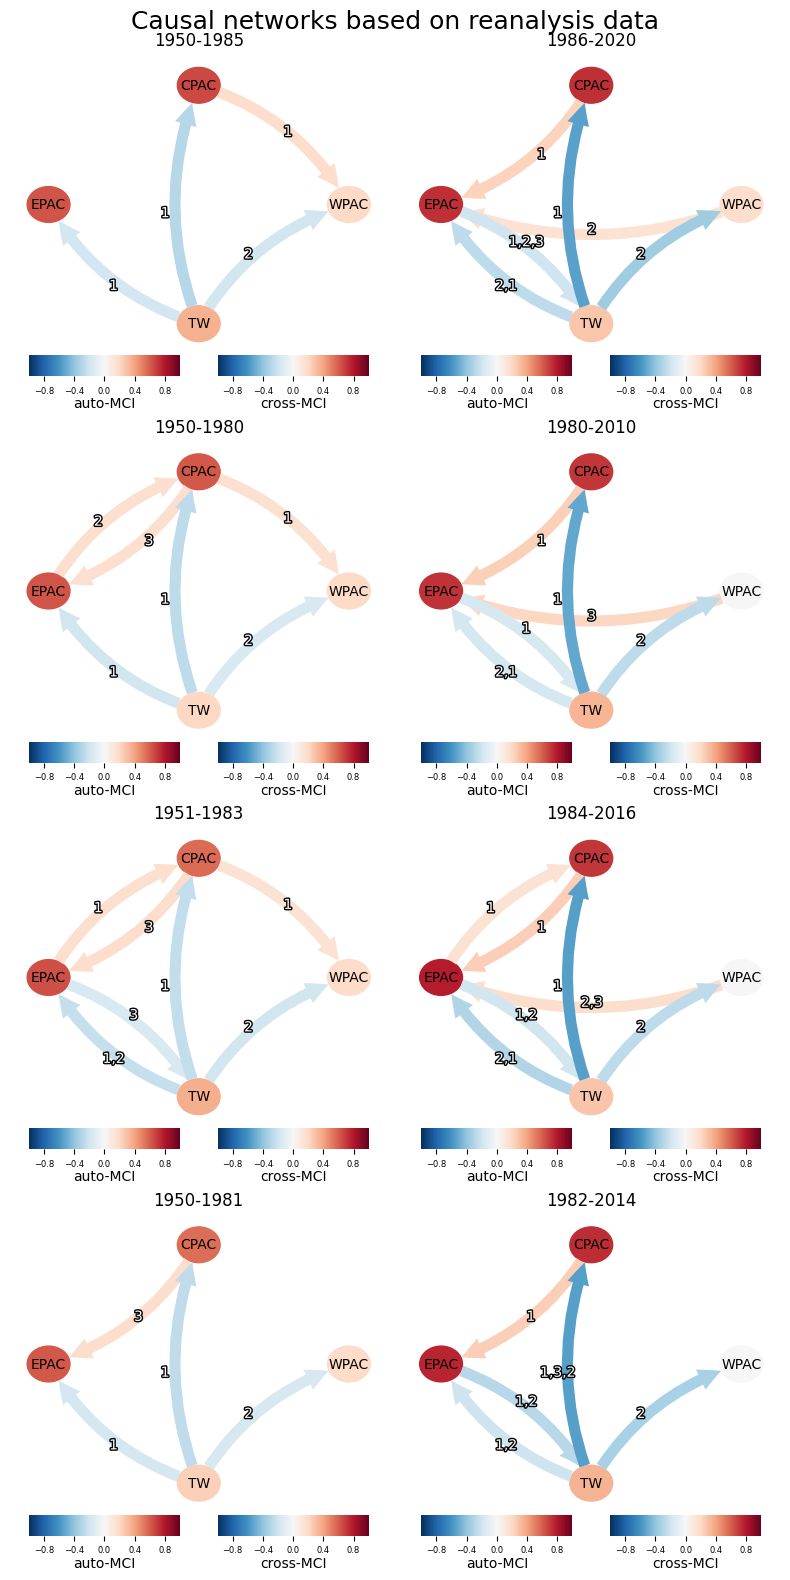

In [36]:
test1_1vroeg, test1_2vroeg, test1_3vroeg, test1_4vroeg, test1_1laat, test1_2laat, test1_3laat, test1_4laat = link_robustness(extended_data, parcorr, extended = 1)
var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']

In [37]:
# print(test1_4vroeg['val_matrix'])
# print(test1_4vroeg['conf_matrix'])
# print(test1_4laat['val_matrix'])

### Adjust graphs to robust graphs 

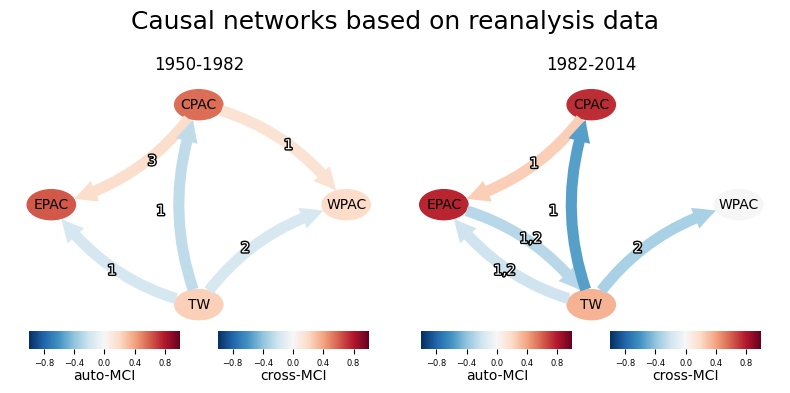

In [38]:
graph_vroeg_fournode = np.array([[['', '-->', '', ''],
        ['', '', '', ''],
        ['', '', '', ''],
        ['', '', '', '']],

       [['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '', '', '-->'],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '', '', ''],
        ['', '-->', '', ''],
        ['', '', '', '']],

       [['', '', '-->', ''],
        ['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '-->', '']]], dtype='<U3')

graph_laat_fournode = np.array([[['', '', '', ''],
        ['', '', '', ''],
        ['', '', '', ''],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '', '', ''],
        ['', '-->', '-->', ''],
        ['', '-->', '-->', '']],

       [['', '', '-->', ''],
        ['', '-->', '', ''],
        ['', '-->', '-->', ''],
        ['', '-->', '-->', '']]], dtype='<U3')

fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
tp.plot_graph(
            val_matrix=test1_4vroeg['val_matrix'],
            graph=graph_vroeg_fournode,
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0]))
axes[0].set_title('1950-1982')

tp.plot_graph(
            val_matrix=test1_4laat['val_matrix'],
            graph=graph_laat_fournode,
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1]))
axes[1].set_title('1982-2014')

fig.suptitle(f'Causal networks based on reanalysis data', fontsize = 18)
    
plt.subplots_adjust(hspace=0.8)
plt.show()

In [39]:
# print(graph_vroeg_fournode)
# print(test1_4vroeg['val_matrix'])
# print(test1_4vroeg['conf_matrix'])
# print(test1_4laat['val_matrix'])
# print(test1_4laat['conf_matrix'])

## Five node networks 

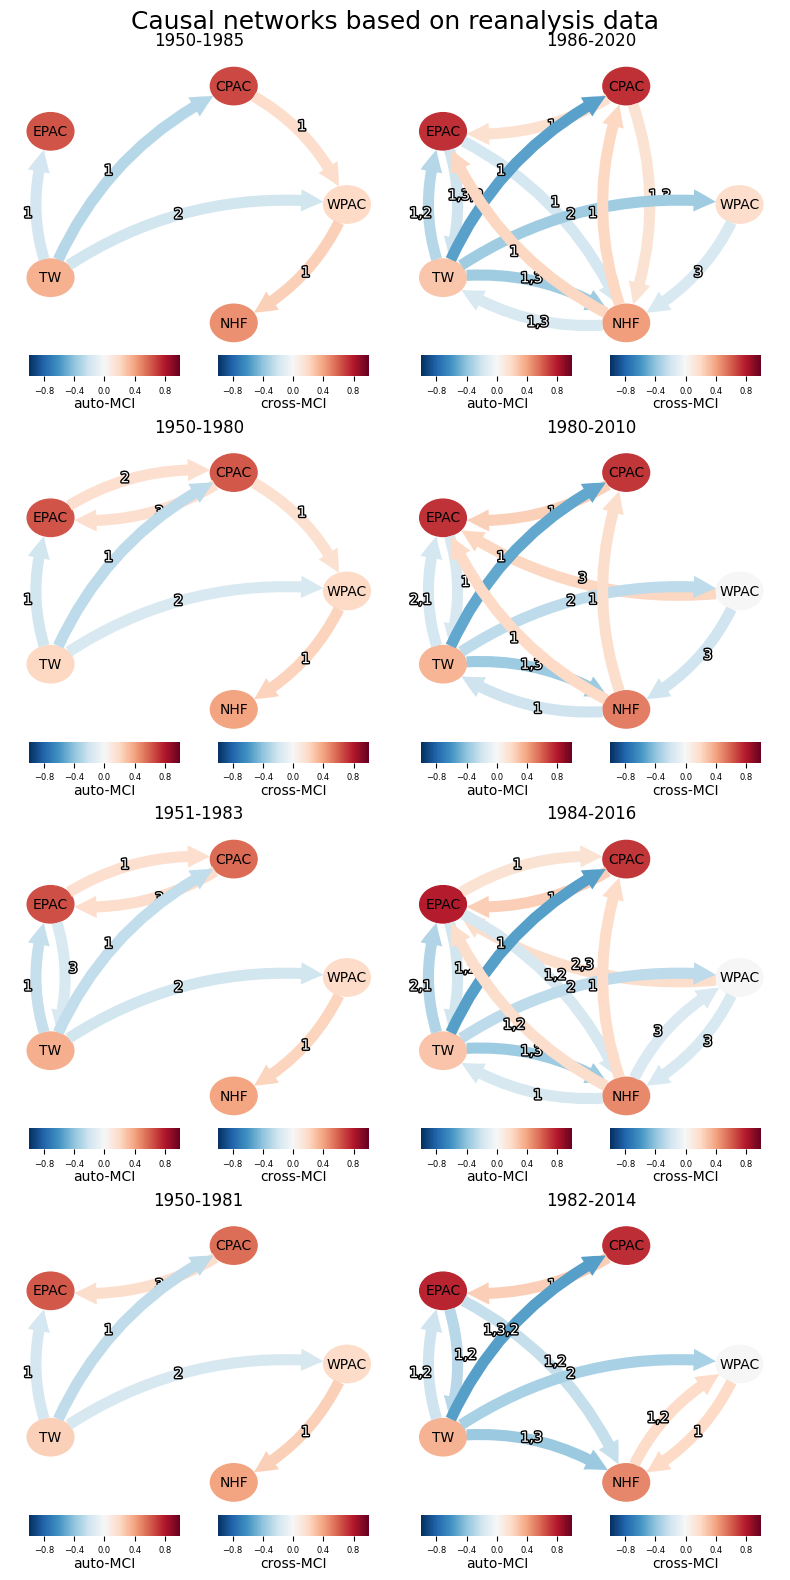

In [40]:
test2_1vroeg, test2_2vroeg, test2_3vroeg, test2_4vroeg, test2_1laat, test2_2laat, test2_3laat, test2_4laat  = link_robustness(extended_data, parcorr, extended = 2)


In [41]:
# test2_4vroeg['graph']

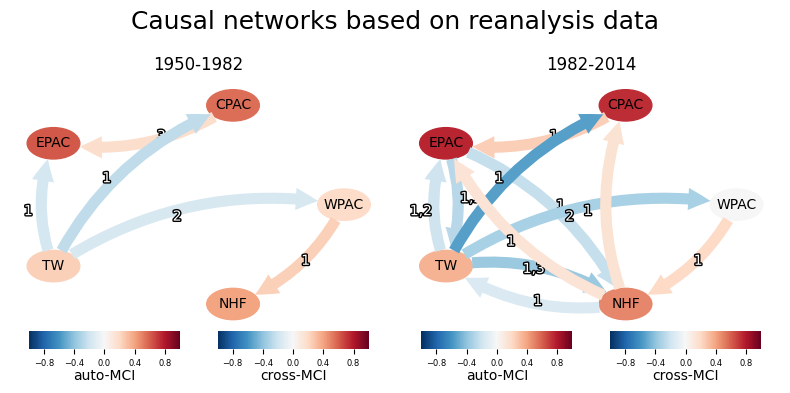

In [42]:
graph_vroeg_fivenode = np.array([[['', '-->', '', ''],
        ['', '', '', ''],
        ['', '', '', ''],
        ['', '', '', ''],
        ['', '-->', '', '']],

       [['', '', '', ''],
        ['', '-->', '', ''],
        ['', '', '', '-->'],
        ['', '', '', ''],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '', '', ''],
        ['', '-->', '', ''],
        ['', '', '', ''],
        ['', '', '', '']],

       [['', '', '-->', ''],
        ['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '-->', ''],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '', '', ''],
        ['', '', '', ''],
        ['', '', '', ''],
        ['', '-->', '-->', '']]], dtype='<U3')

graph_laat_fivenode = np.array([[['', '', '', ''],
        ['', '', '', ''],
        ['', '', '', ''],
        ['', '', '', ''],
        ['', '-->', '', '']],

       [['', '', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '', '', ''],
        ['', '', '', '']],

       [['', '', '', ''],
        ['', '', '', ''],
        ['', '-->', '-->', ''],
        ['', '-->', '-->', ''],
        ['', '-->', '', '']],

       [['', '', '-->', ''],
        ['', '-->', '', ''],
        ['', '-->', '-->', ''],
        ['', '-->', '-->', ''],
        ['', '-->', '', '-->']],

       [['', '', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '', ''],
        ['', '-->', '-->', '']]], dtype='<U3')

var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
tp.plot_graph(
            val_matrix=test2_4vroeg['val_matrix'],
            graph=graph_vroeg_fivenode,
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0]))
axes[0].set_title('1950-1982')

tp.plot_graph(
            val_matrix=test2_4laat['val_matrix'],
            graph=graph_laat_fivenode,
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1]))
axes[1].set_title('1982-2014')

fig.suptitle(f'Causal networks based on reanalysis data', fontsize = 18)
    
plt.subplots_adjust(hspace=0.8)
plt.show()

In [43]:

# print(test2_4vroeg['val_matrix'])
# print(test2_4vroeg['conf_matrix'])
# print(test2_4laat['val_matrix'])
# print(test2_4laat['conf_matrix'])

# PLOT OF THE DATA

In [44]:
# function to detrend + deseazonalize data
def deTrend_deSeasonalizeplots(data, show_plot = True):
    # step 1: seasonal component
    index = range(0, len(data))
    
    plt.plot(index, data)
    plt.title("Deseasonalized data with smoothed trend")
    plt.show()
    
    decomposition = seasonal_decompose(data, model='additive', period=12)
    data = data - decomposition.seasonal
    # step 2: Trend based on Gaussian kernel smoother
    smoothed = pp.smooth(np.copy(data), smooth_width=15 * 12, residuals=False)
    

    if show_plot == True:
        plt.plot(index, data)
        plt.plot(index,smoothed)
        plt.legend(['data', 'Smoothed trend'])
        plt.title("Deseasonalized data with smoothed trend")
        plt.show()

    else:
        result = data - smoothed
        return result

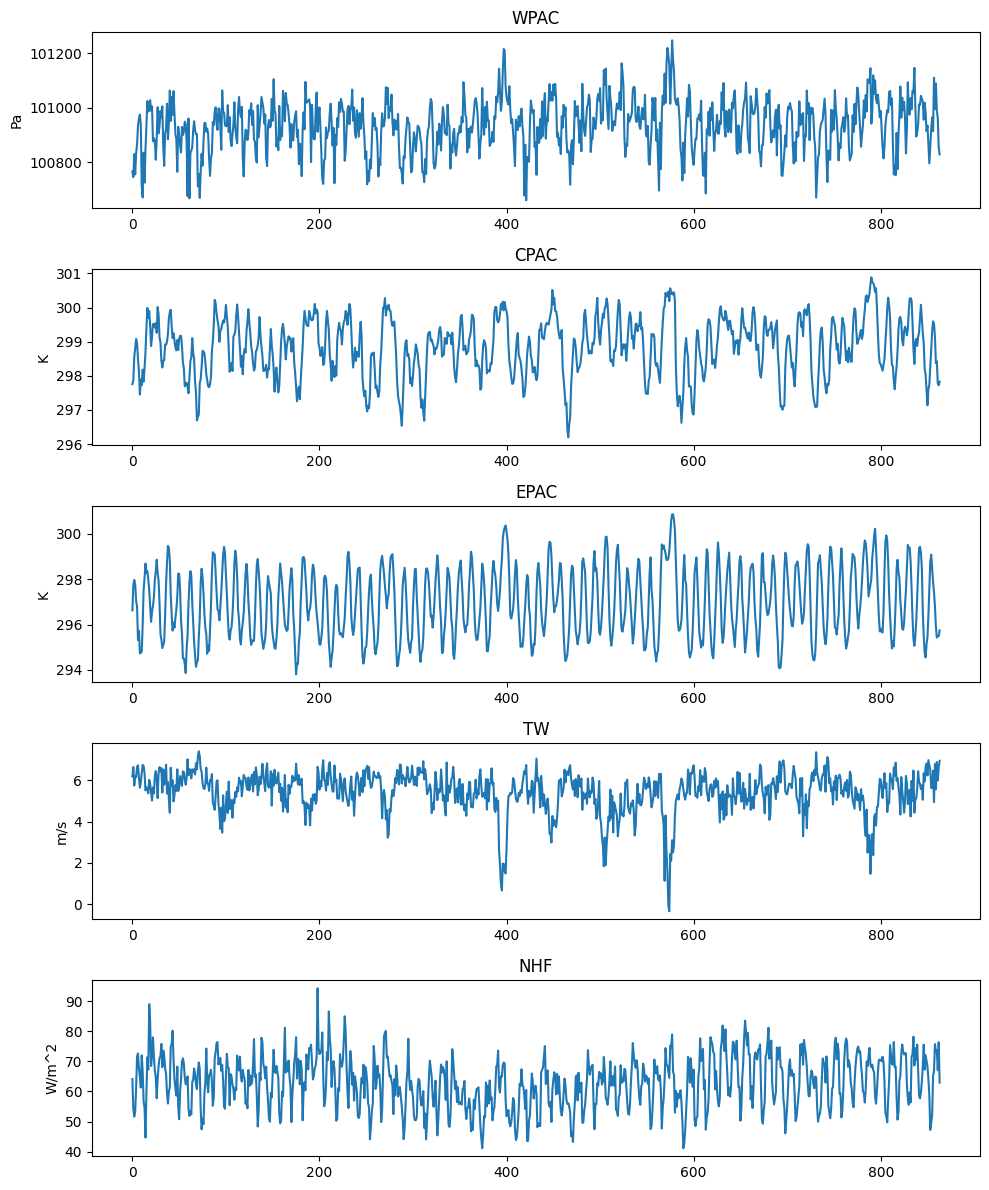

In [45]:
from datetime import datetime
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
# Create a list of plot titles
plot_titles = ['WPAC', 'CPAC', 'EPAC',
               'TW', 'NHF']

value = ['Pa', 'K', 'K', 'm/s', 'W/m^2']

# Create subplots with separate plots for each variable
fig, axes = plt.subplots(len(plot_titles), 1, figsize=(10, 12))  # Adjust figsize as per your requirement

# Create a datetime range for the x-axis
start_year = 1950
end_year = 2022
num_months = extended_data.shape[0]
dates = [datetime(year, month, 1) for year in range(start_year, end_year + 1) for month in range(1, 13)]

years = range(1950, 2023)  # 2023 since we include the end year

# Iterate over each variable and plot it in a separate subplot
for i, ax in enumerate(axes):
    ax.plot(extended_data[:, i])
    ax.set_title(plot_titles[i])
    ax.set_ylabel(value[i])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()



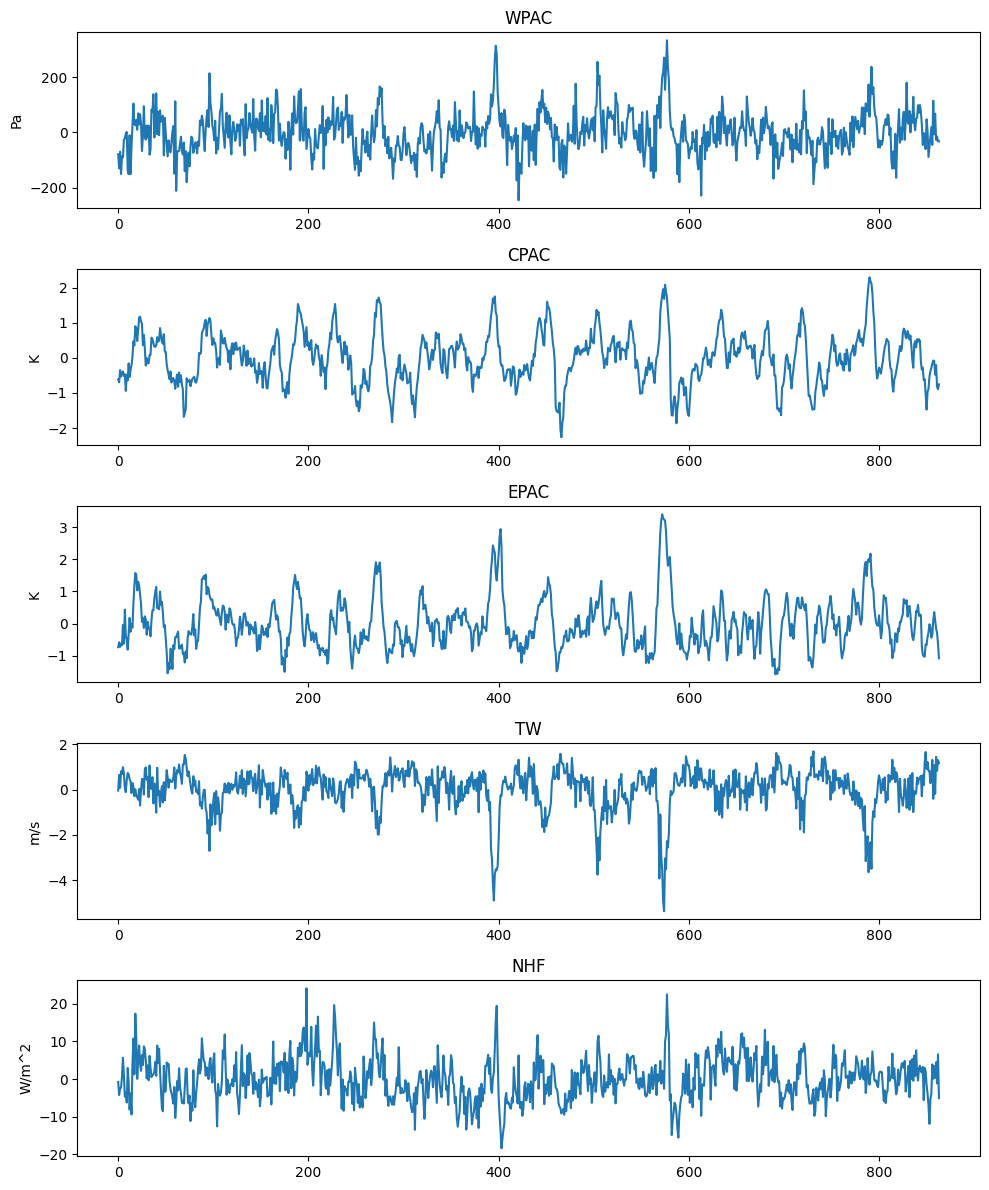

In [46]:
var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

# make data frame of data
df_GFDL = pd.DataFrame(extended_data, columns=var_names)

cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
nhf_detrend = deTrend_deSeasonalize(df_GFDL['NHF'], show_plot = False)

df_extended_processed = np.vstack((wpac_detrend_GFDL, cpac_detrend_GFDL, epac_detrend_GFDL, zws_detrend, nhf_detrend)).T

# Create a list of plot titles
plot_titles = ['WPAC', 'CPAC', 'EPAC',
               'TW', 'NHF']

value = ['Pa', 'K', 'K', 'm/s', 'W/m^2']

# Create subplots with separate plots for each variable
fig, axes = plt.subplots(len(plot_titles), 1, figsize=(10, 12))  # Adjust figsize as per your requirement

# Create a datetime range for the x-axis
start_year = 1950
end_year = 2022
num_months = df_extended_processed.shape[0]
dates = [datetime(year, month, 1) for year in range(start_year, end_year + 1) for month in range(1, 13)]

years = range(1950, 2023)  # 2023 since we include the end year

# Iterate over each variable and plot it in a separate subplot
for i, ax in enumerate(axes):
    ax.plot(df_extended_processed[:, i])
    ax.set_title(plot_titles[i])
    ax.set_ylabel(value[i])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()




# Density plots and scatter plots

<Figure size 1500x1500 with 0 Axes>

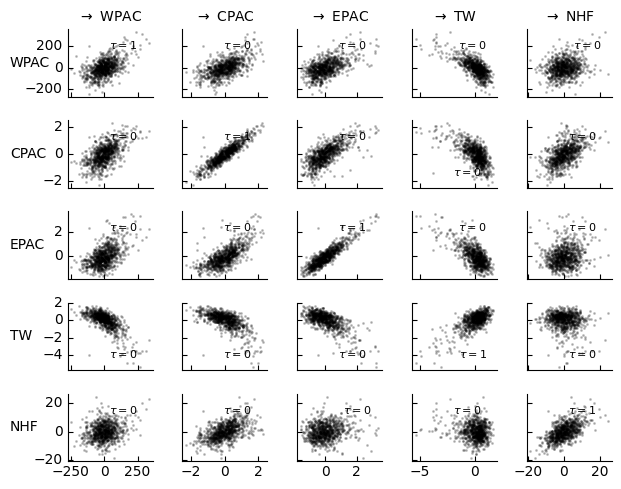

<Figure size 1500x1500 with 0 Axes>

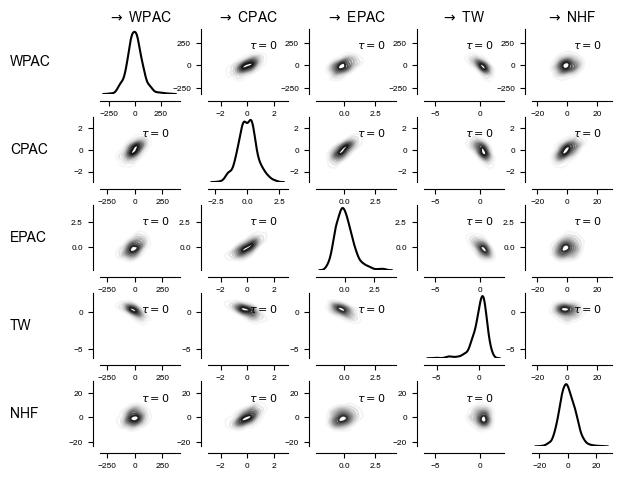

In [51]:
var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

# make data frame of data
df_GFDL = pd.DataFrame(extended_data, columns=var_names)
dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
nhf_detrend = deTrend_deSeasonalize(df_GFDL['NHF'], show_plot = False)
        
df_extended = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend,
                                        'NHF': nhf_detrend})


dataframe_extended = pp.DataFrame(np.copy(df_extended), datatime = {0:np.arange(len(df_extended))}, var_names= var_names)
fig = plt.figure(figsize=(15, 15))  
tp.plot_scatterplots(dataframe=dataframe_extended)
plt.show()
fig = plt.figure(figsize=(15, 15))
tp.plot_densityplots(dataframe=dataframe_extended)
plt.show()



# Analysis for all years

# Reanalysis analysis

Reanalysis results
p-value PhillipsPerron test cpac: 2.1997765168193367e-07
p-value PhillipsPerron test epac: 6.928981097927765e-08
p-value PhillipsPerron test wpac: 0.0
p-value Shapiro-Wilk test cpac: 0.028344880789518356
p-value Shapiro-Wilk test epac: 9.481604755247873e-17
p-value Shapiro-Wilk test wpac: 8.321854316761801e-09
Number of nino years Reanalysis:  15
Number of nina years Reanalysis:  32
Number of neutral years Reanalysis:  25


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

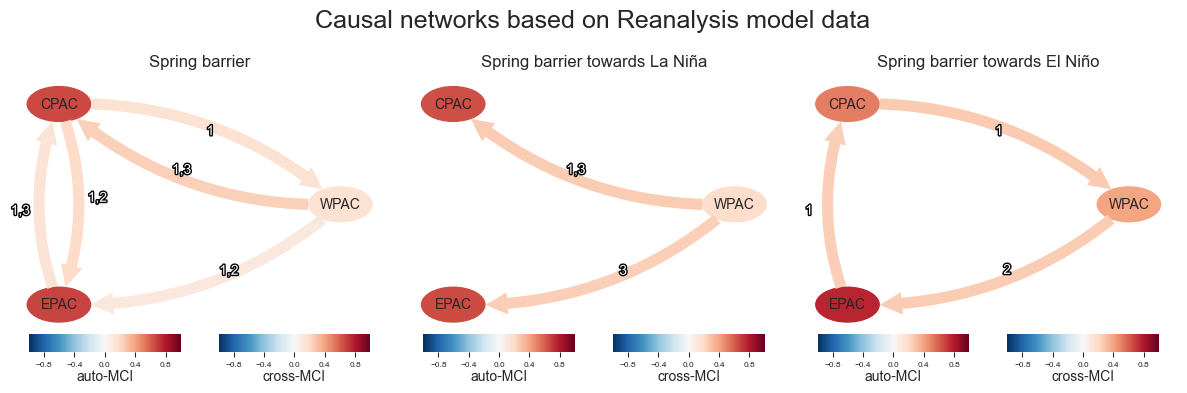

In [52]:
results_springbarrier_reanalysis, results_nina_reanalysis, results_nino_reanalysis = mainfunction(reanalysis_data, nino34reanalysis, reanalysis, parcorr)


# GFDL_ESM4 analysis

GFDL_ESM4 results
p-value PhillipsPerron test cpac: 1.104061212694666e-07
p-value PhillipsPerron test epac: 3.178274712522455e-19
p-value PhillipsPerron test wpac: 0.0
p-value Shapiro-Wilk test cpac: 0.0600883811712265
p-value Shapiro-Wilk test epac: 0.0002140786382369697
p-value Shapiro-Wilk test wpac: 2.4094183004308434e-07
Number of nino years GFDL_ESM4:  17
Number of nina years GFDL_ESM4:  34
Number of neutral years GFDL_ESM4:  21


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

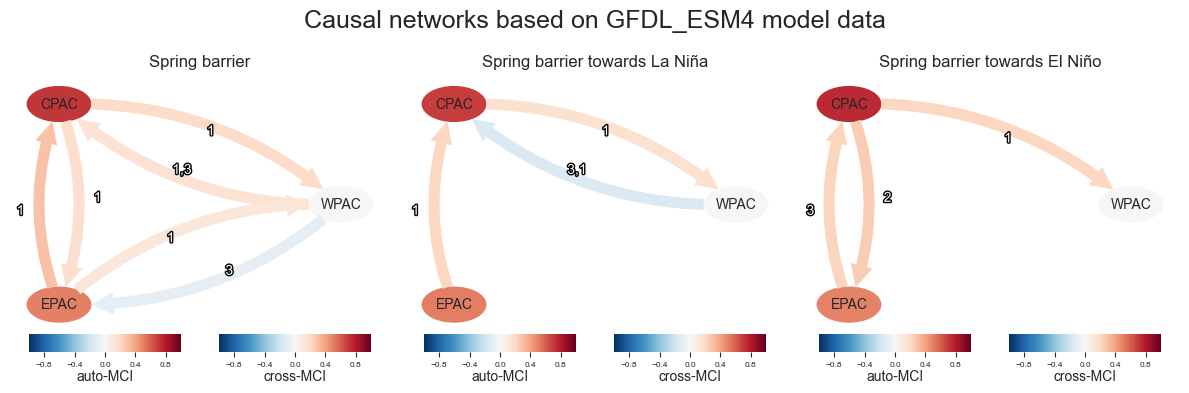

F1 score springbarrier model GFDL_ESM4:  0.56
F1 score nina model GFDL_ESM4:  0.5
F1 score nino model GFDL_ESM4:  0.5


In [53]:
results_springbarrier_GFDL, results_nina_GFDL, results_nino_GFDL = mainfunction(GFDL_data, nino34GFDL, GFDL_ESM4, parcorr)
score_function(GFDL_ESM4,
                  results_springbarrier_reanalysis,
                  results_nina_reanalysis, 
                  results_nino_reanalysis,
                  results_springbarrier_GFDL,
                  results_nina_GFDL,
                  results_nino_GFDL
                  )

## EC Earth analysis

EC-Earth3 results
p-value PhillipsPerron test cpac: 1.1352321227446008e-06
p-value PhillipsPerron test epac: 3.774769575679175e-13
p-value PhillipsPerron test wpac: 0.0
p-value Shapiro-Wilk test cpac: 2.3985458028619178e-05
p-value Shapiro-Wilk test epac: 9.468096322962083e-06
p-value Shapiro-Wilk test wpac: 1.2866341592143726e-07
Number of nino years EC-Earth3:  20
Number of nina years EC-Earth3:  17
Number of neutral years EC-Earth3:  35


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

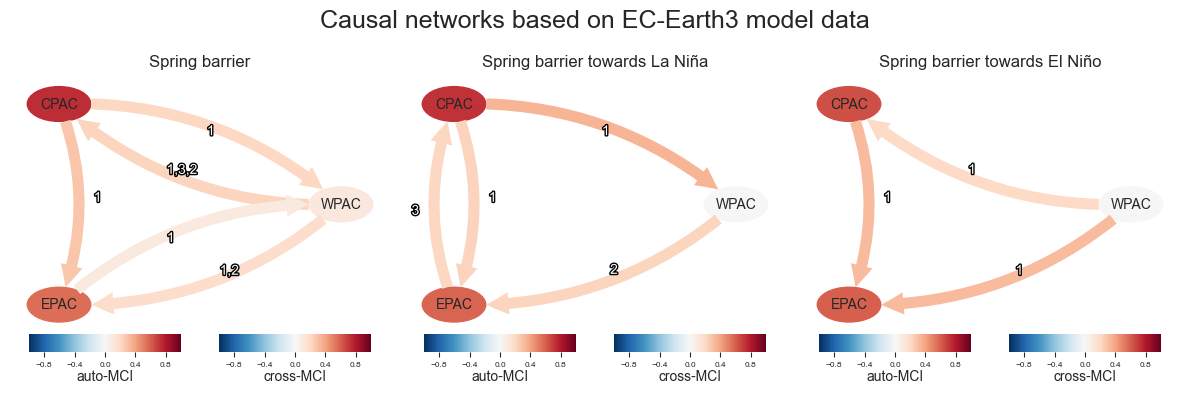

F1 score springbarrier model EC-Earth3:  0.7200000000000001
F1 score nina model EC-Earth3:  0.28571428571428575
F1 score nino model EC-Earth3:  0.3636363636363636
[[[ 0.00000000e+00  7.32703377e-02  1.06332630e-01  7.03323518e-02]
  [ 0.00000000e+00  2.22619164e-01 -1.02465438e-01 -1.21542338e-01]
  [ 0.00000000e+00  1.83716480e-01  1.39342173e-01 -4.83041624e-04]]

 [[ 0.00000000e+00  2.04309123e-01  3.08843298e-02 -5.21537017e-02]
  [ 0.00000000e+00  7.39935561e-01 -2.59421647e-02  6.96117134e-03]
  [ 0.00000000e+00  2.78053393e-01 -3.82737255e-02 -5.61418253e-02]]

 [[ 0.00000000e+00  9.99591810e-02 -3.35448061e-02  2.56611854e-02]
  [ 0.00000000e+00  4.53723031e-02 -3.34005622e-02  4.09971000e-02]
  [ 0.00000000e+00  5.55658411e-01 -5.86604050e-02 -3.98985619e-02]]]


In [54]:
results_springbarrier_ecearth, results_nina_ecearth, results_nino_ecearth = mainfunction(ecearth_data, nino34ecearth, ecearth, parcorr)
score_function(ecearth,
                  results_springbarrier_reanalysis,
                  results_nina_reanalysis, 
                  results_nino_reanalysis,
                  results_springbarrier_ecearth,
                  results_nina_ecearth,
                  results_nino_ecearth
                  )

print(results_springbarrier_ecearth['val_matrix'])

## CESM2 analysis

CESM2 results
p-value PhillipsPerron test cpac: 2.8197057080893076e-06
p-value PhillipsPerron test epac: 9.018605500648461e-07
p-value PhillipsPerron test wpac: 8.697858369770432e-29
p-value Shapiro-Wilk test cpac: 0.0005408489960245788
p-value Shapiro-Wilk test epac: 0.147652730345726
p-value Shapiro-Wilk test wpac: 4.255489898241649e-07
Number of nino years CESM2:  22
Number of nina years CESM2:  33
Number of neutral years CESM2:  17


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

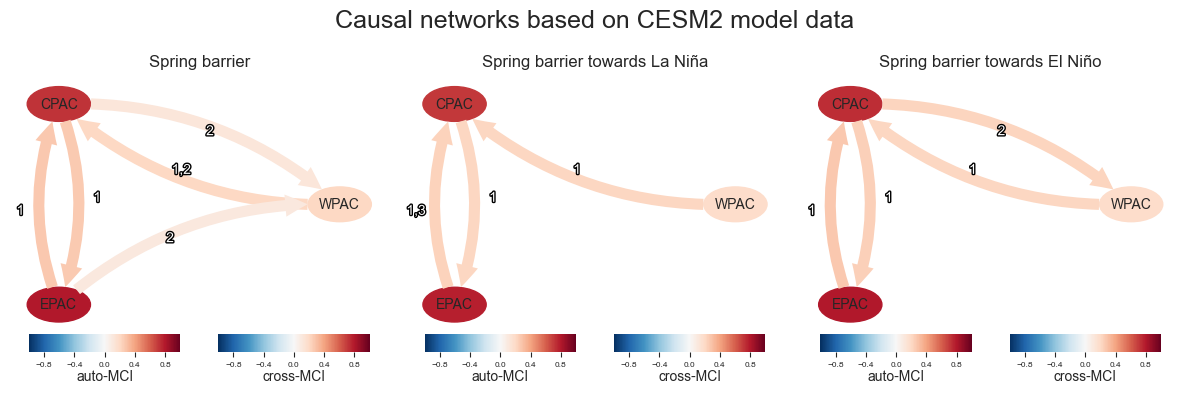

F1 score springbarrier model CESM2:  0.5384615384615384
F1 score nina model CESM2:  0.5882352941176471
F1 score nino model CESM2:  0.42857142857142855


In [55]:
results_springbarrier_CESM2, results_nina_CESM2, results_nino_CESM2 = mainfunction(CESM2_data, nino34CESM2, CESM2, parcorr)
score_function(CESM2,
                  results_springbarrier_reanalysis,
                  results_nina_reanalysis, 
                  results_nino_reanalysis,
                  results_springbarrier_CESM2,
                  results_nina_CESM2,
                  results_nino_CESM2
                  )

## MIROC6 analysis

MIROC6 results
p-value PhillipsPerron test cpac: 2.234847665609732e-06
p-value PhillipsPerron test epac: 5.386119320016682e-08
p-value PhillipsPerron test wpac: 0.0
p-value Shapiro-Wilk test cpac: 1.0213117093371693e-05
p-value Shapiro-Wilk test epac: 3.2051121739290478e-12
p-value Shapiro-Wilk test wpac: 3.058742426009786e-10
Number of nino years MIROC6:  16
Number of nina years MIROC6:  44
Number of neutral years MIROC6:  12


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

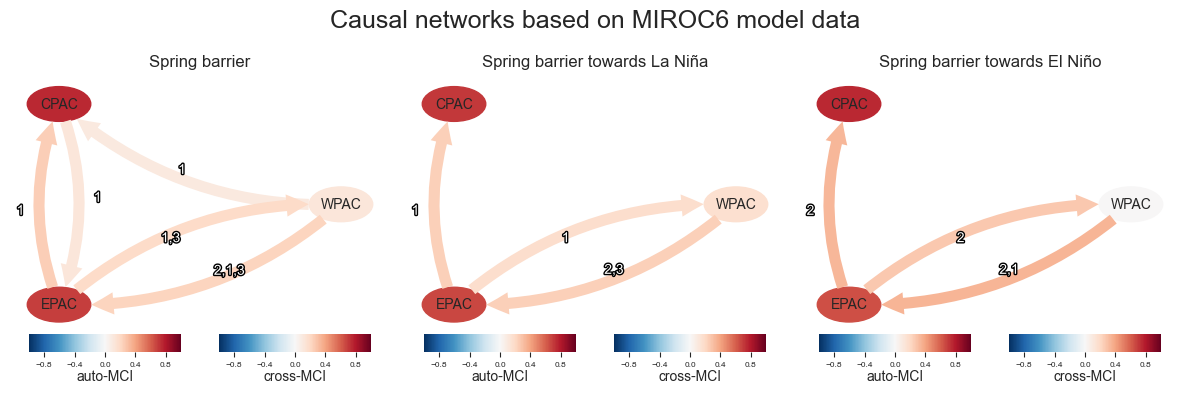

F1 score springbarrier model MIROC6:  0.6923076923076924
F1 score nina model MIROC6:  0.5333333333333333
F1 score nino model MIROC6:  0.5


In [56]:
results_springbarrier_MIROC6, results_nina_MIROC6, results_nino_MIROC6 = mainfunction(MIROC6_data, nino34MIROC6, MIROC6, parcorr)
score_function(MIROC6,
                  results_springbarrier_reanalysis,
                  results_nina_reanalysis, 
                  results_nino_reanalysis,
                  results_springbarrier_MIROC6,
                  results_nina_MIROC6,
                  results_nino_MIROC6
                  )

# COMPARISON: 1950-1985 vs 1985-2020

## Reanalysis

Reanalysis results
p-value PhillipsPerron test cpac: 2.1997765168193367e-07
p-value PhillipsPerron test epac: 6.928981097927765e-08
p-value PhillipsPerron test wpac: 0.0
p-value Shapiro-Wilk test cpac: 0.028344880789518356
p-value Shapiro-Wilk test epac: 9.481604755247873e-17
p-value Shapiro-Wilk test wpac: 8.321854316761801e-09
Number of nino years Reanalysis:  15
Number of nina years Reanalysis:  32
Number of neutral years Reanalysis:  25


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

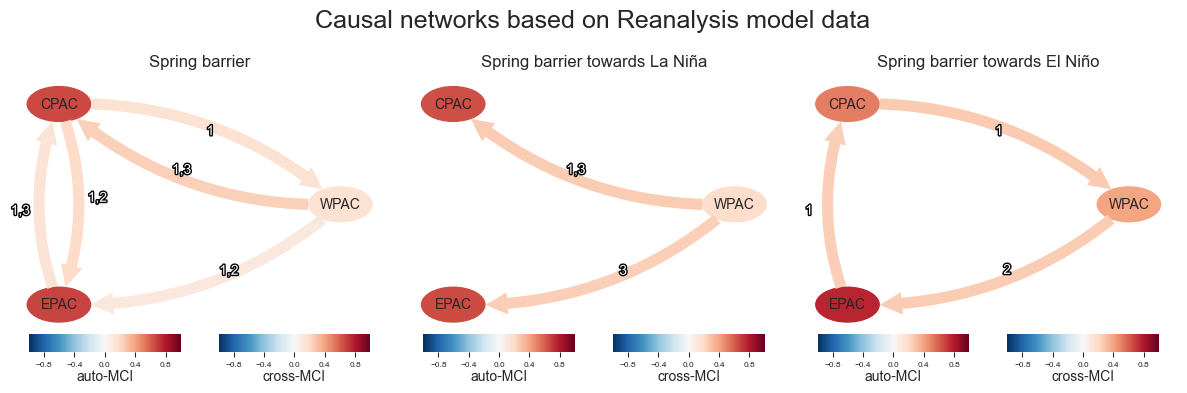

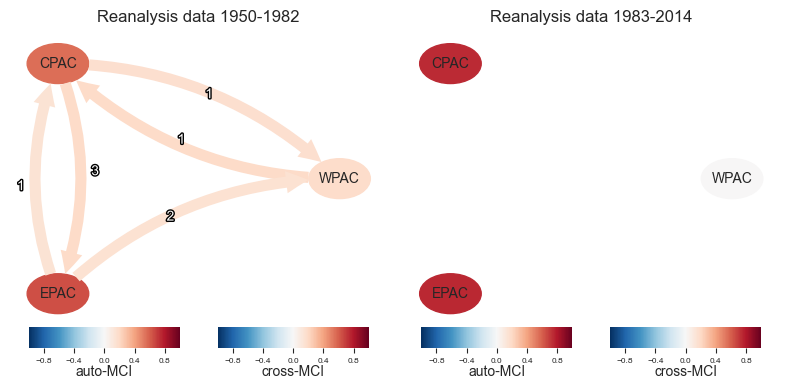

Number of nino years before 1985:  9
Number of nina years before 1985:  14
Number of neutral years before 1985:  9
Number of significant links based on data before 1985: 9
Mean strength of significant links based on data before 1985: 0.2638978599018856
Number of nino years after 1985:  5
Number of nina years after 1985:  14
Number of neutral years after 1985:  13
Number of significant links based on data after 1985: 11
Mean strength of significant links based on data after 1985: 0.30102808698985534


({'graph': array([[['', '-->', '', ''],
          ['', '-->', '', ''],
          ['', '', '', '']],
  
         [['', '-->', '', ''],
          ['', '-->', '', ''],
          ['', '', '', '-->']],
  
         [['', '', '-->', ''],
          ['', '-->', '', ''],
          ['', '-->', '-->', '']]], dtype='<U3'),
  'p_matrix': array([[[1.00000000e+00, 1.08301066e-02, 1.02289934e-01, 9.26317089e-01],
          [1.00000000e+00, 1.03493077e-02, 7.44718813e-01, 6.12492310e-01],
          [1.00000000e+00, 1.02289934e-01, 4.12167807e-01, 9.31435835e-01]],
  
         [[1.00000000e+00, 1.87918878e-02, 5.56882162e-01, 3.07875609e-01],
          [1.00000000e+00, 4.56846040e-23, 4.72931185e-01, 4.54624026e-01],
          [1.00000000e+00, 8.56082386e-02, 8.24283465e-01, 1.03493077e-02]],
  
         [[1.00000000e+00, 8.24283465e-01, 4.16674364e-02, 5.56882162e-01],
          [1.00000000e+00, 4.91939405e-02, 4.54624026e-01, 5.47870555e-01],
          [1.00000000e+00, 1.37090115e-32, 4.16674364e-02, 7

In [57]:
results_springbarrier_reanalysis, results_nina_reanalysis, results_nino_reanalysis = mainfunction(reanalysis_data, nino34reanalysis, reanalysis, parcorr)

firsthalf_lasthalf(reanalysis_data, nino34reanalysis, reanalysis, parcorr)



## GFDL_ESM4 analysis

GFDL_ESM4 results
p-value PhillipsPerron test cpac: 1.104061212694666e-07
p-value PhillipsPerron test epac: 3.178274712522455e-19
p-value PhillipsPerron test wpac: 0.0
p-value Shapiro-Wilk test cpac: 0.0600883811712265
p-value Shapiro-Wilk test epac: 0.0002140786382369697
p-value Shapiro-Wilk test wpac: 2.4094183004308434e-07
Number of nino years GFDL_ESM4:  17
Number of nina years GFDL_ESM4:  34
Number of neutral years GFDL_ESM4:  21


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

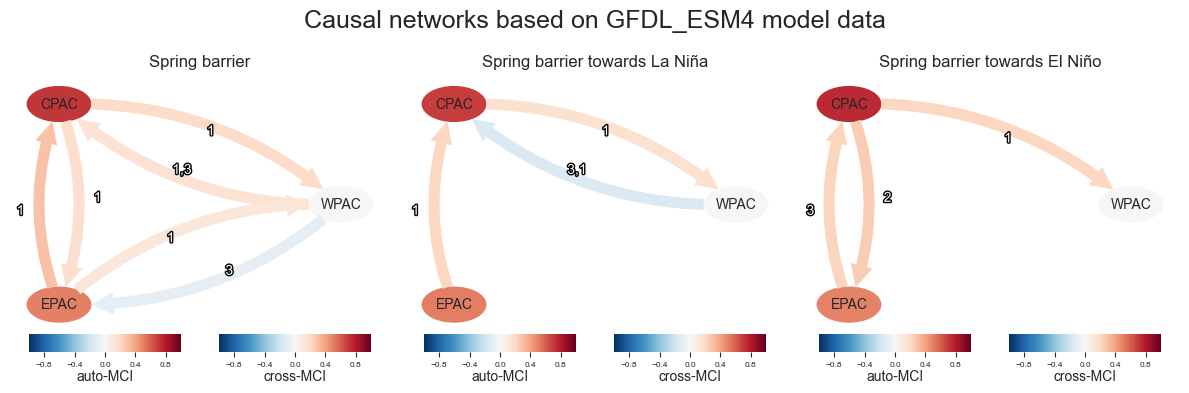

F1 score springbarrier model GFDL_ESM4:  0.56
F1 score nina model GFDL_ESM4:  0.5
F1 score nino model GFDL_ESM4:  0.5


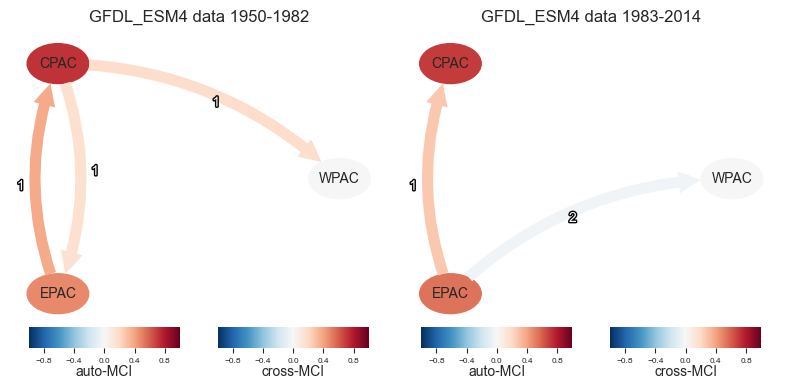

Number of nino years before 1985:  8
Number of nina years before 1985:  13
Number of neutral years before 1985:  11
Number of significant links based on data before 1985: 6
Mean strength of significant links based on data before 1985: 0.36685173805496335
Number of nino years after 1985:  7
Number of nina years after 1985:  15
Number of neutral years after 1985:  10
Number of significant links based on data after 1985: 7
Mean strength of significant links based on data after 1985: 0.34522258212126605


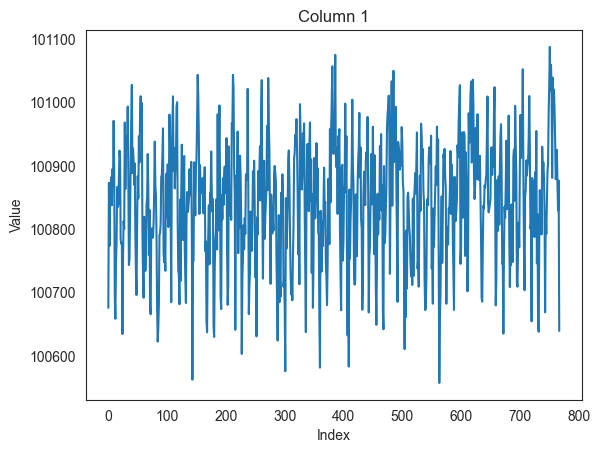

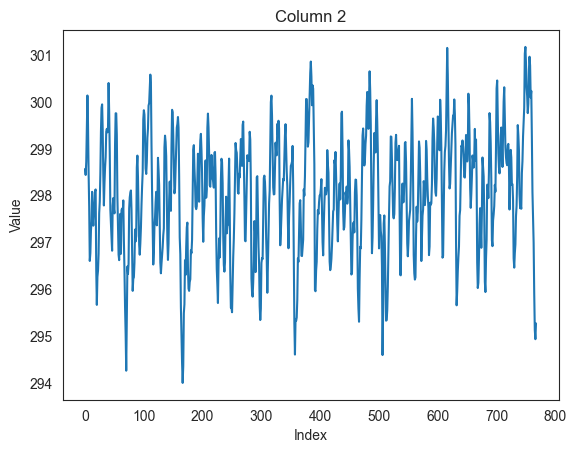

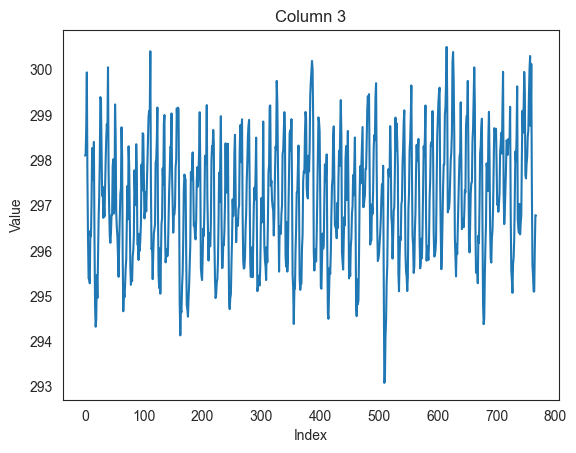

In [58]:
results_springbarrier_GFDL, results_nina_GFDL, results_nino_GFDL = mainfunction(GFDL_data, nino34GFDL, GFDL_ESM4, parcorr)
score_function(GFDL_ESM4,
                  results_springbarrier_reanalysis,
                  results_nina_reanalysis, 
                  results_nino_reanalysis,
                  results_springbarrier_GFDL,
                  results_nina_GFDL,
                  results_nino_GFDL
                  )

firsthalf_lasthalf(GFDL_data, nino34GFDL, GFDL_ESM4, parcorr)

num_columns = GFDL_data.shape[1]

# Create separate plots for each column
for i in range(num_columns):
    plt.figure()  # Create a new figure for each plot
    plt.plot(GFDL_data[:-96, i])  # Plot the values of the current column
    plt.title('Column {}'.format(i+1))  # Set a title for the plot
    plt.xlabel('Index')  # Set the x-axis label
    plt.ylabel('Value')  # Set the y-axis label
# Display all the plots
plt.show()

## EC Earth 

EC-Earth3 results
p-value PhillipsPerron test cpac: 1.1352321227446008e-06
p-value PhillipsPerron test epac: 3.774769575679175e-13
p-value PhillipsPerron test wpac: 0.0
p-value Shapiro-Wilk test cpac: 2.3985458028619178e-05
p-value Shapiro-Wilk test epac: 9.468096322962083e-06
p-value Shapiro-Wilk test wpac: 1.2866341592143726e-07
Number of nino years EC-Earth3:  20
Number of nina years EC-Earth3:  17
Number of neutral years EC-Earth3:  35


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

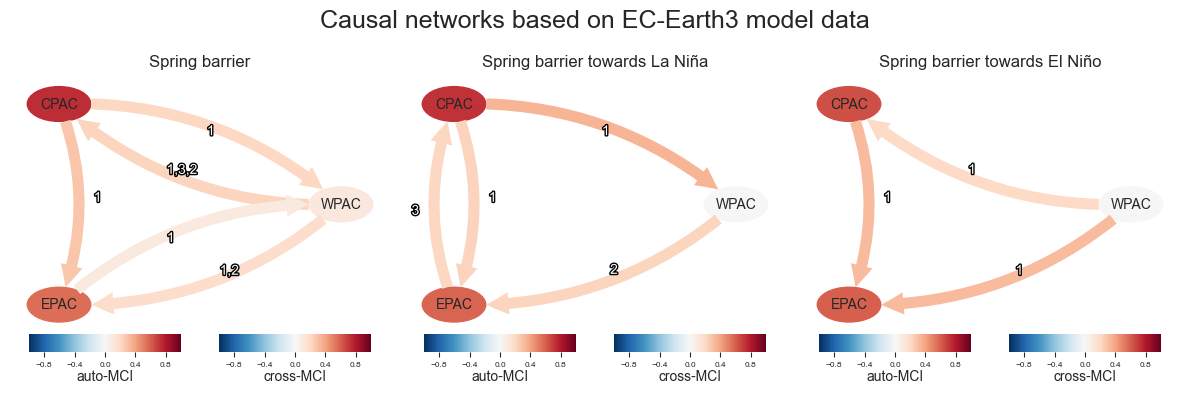

F1 score springbarrier model EC-Earth3:  0.7200000000000001
F1 score nina model EC-Earth3:  0.28571428571428575
F1 score nino model EC-Earth3:  0.3636363636363636


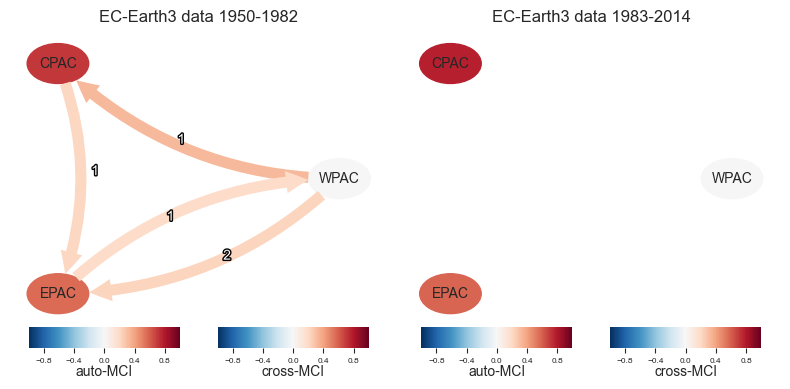

Number of nino years before 1985:  9
Number of nina years before 1985:  10
Number of neutral years before 1985:  13
Number of significant links based on data before 1985: 6
Mean strength of significant links based on data before 1985: 0.37204721862899787
Number of nino years after 1985:  8
Number of nina years after 1985:  5
Number of neutral years after 1985:  19
Number of significant links based on data after 1985: 5
Mean strength of significant links based on data after 1985: 0.43053787360178786
[[[ 0.          0.03722193  0.08654692  0.09650909]
  [ 0.          0.32805039 -0.0477866  -0.111332  ]
  [ 0.          0.10688767  0.21898789 -0.10224875]]

 [[ 0.          0.07168996  0.09618108  0.01550207]
  [ 0.          0.71005649  0.03024353  0.04174901]
  [ 0.          0.21767649  0.00789478  0.02198923]]

 [[ 0.          0.19068277 -0.05485928  0.01170957]
  [ 0.          0.11573513 -0.01779461 -0.06636686]
  [ 0.          0.56682929 -0.02292553 -0.10775319]]]
[[[ 0.00000000e+00  1.

In [59]:
results_springbarrier_ecearth, results_nina_ecearth, results_nino_ecearth = mainfunction(ecearth_data, nino34ecearth, ecearth, parcorr)
score_function(ecearth,
                  results_springbarrier_reanalysis,
                  results_nina_reanalysis, 
                  results_nino_reanalysis,
                  results_springbarrier_ecearth,
                  results_nina_ecearth,
                  results_nino_ecearth
                  )

ecearth_firsthalf, ecearth_lasthalf = firsthalf_lasthalf(ecearth_data, nino34ecearth, ecearth, parcorr)

print(ecearth_firsthalf['val_matrix'])
print(ecearth_lasthalf['val_matrix'])


## CESM2 

CESM2 results
p-value PhillipsPerron test cpac: 2.8197057080893076e-06
p-value PhillipsPerron test epac: 9.018605500648461e-07
p-value PhillipsPerron test wpac: 8.697858369770432e-29
p-value Shapiro-Wilk test cpac: 0.0005408489960245788
p-value Shapiro-Wilk test epac: 0.147652730345726
p-value Shapiro-Wilk test wpac: 4.255489898241649e-07
Number of nino years CESM2:  22
Number of nina years CESM2:  33
Number of neutral years CESM2:  17


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

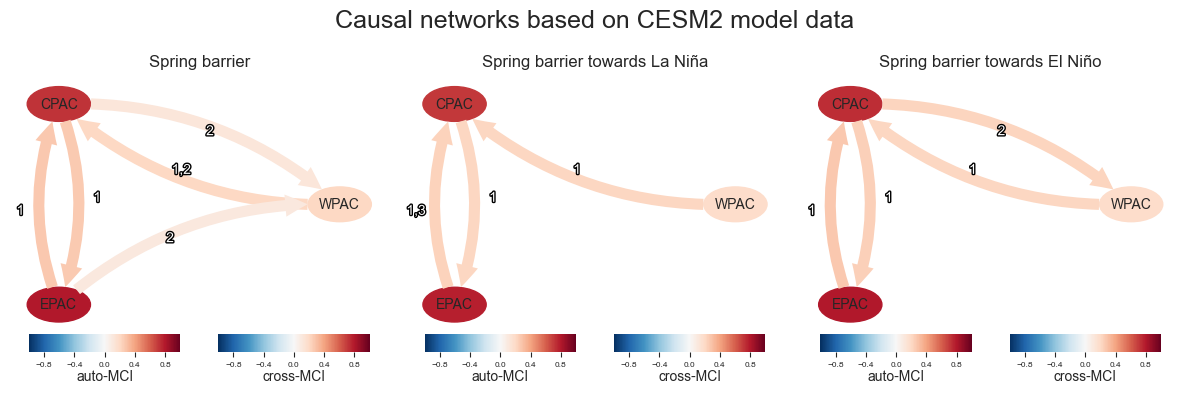

F1 score springbarrier model CESM2:  0.5384615384615384
F1 score nina model CESM2:  0.5882352941176471
F1 score nino model CESM2:  0.42857142857142855


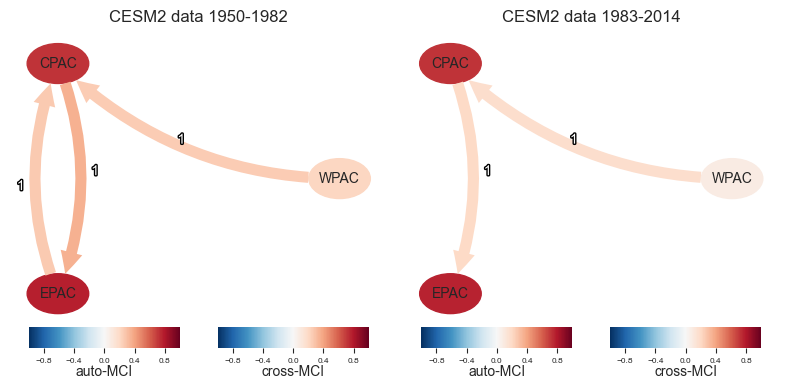

Number of nino years before 1985:  11
Number of nina years before 1985:  16
Number of neutral years before 1985:  5
Number of significant links based on data before 1985: 6
Mean strength of significant links based on data before 1985: 0.42970201496301946
Number of nino years after 1985:  8
Number of nina years after 1985:  13
Number of neutral years after 1985:  11
Number of significant links based on data after 1985: 8
Mean strength of significant links based on data after 1985: 0.3430155650001411


({'graph': array([[['', '', '-->', ''],
          ['', '-->', '', ''],
          ['', '', '', '']],
  
         [['', '', '', ''],
          ['', '-->', '', ''],
          ['', '-->', '', '']],
  
         [['', '', '', ''],
          ['', '-->', '', ''],
          ['', '-->', '', '']]], dtype='<U3'),
  'p_matrix': array([[[1.00000000e+00, 9.02401680e-02, 1.39426369e-03, 5.39565886e-01],
          [1.00000000e+00, 8.78666335e-05, 5.34609367e-01, 1.37250801e-01],
          [1.00000000e+00, 5.05068708e-01, 6.03214458e-01, 5.69502227e-01]],
  
         [[1.00000000e+00, 6.77034803e-01, 1.14756128e-01, 7.29302259e-01],
          [1.00000000e+00, 1.67604835e-44, 9.02401680e-02, 5.39565886e-01],
          [1.00000000e+00, 9.52932044e-09, 7.92665619e-01, 5.39565886e-01]],
  
         [[1.00000000e+00, 7.12865102e-01, 5.60877705e-01, 5.39565886e-01],
          [1.00000000e+00, 6.80886544e-05, 5.34609367e-01, 6.03214458e-01],
          [1.00000000e+00, 3.18379222e-56, 8.25143712e-02, 6.05233415

In [60]:
results_springbarrier_CESM2, results_nina_CESM2, results_nino_CESM2 = mainfunction(CESM2_data, nino34CESM2, CESM2, parcorr)
score_function(CESM2,
                  results_springbarrier_reanalysis,
                  results_nina_reanalysis, 
                  results_nino_reanalysis,
                  results_springbarrier_CESM2,
                  results_nina_CESM2,
                  results_nino_CESM2
                  )
firsthalf_lasthalf(CESM2_data, nino34CESM2, CESM2, parcorr)


## MIROC6

MIROC6 results
p-value PhillipsPerron test cpac: 2.234847665609732e-06
p-value PhillipsPerron test epac: 5.386119320016682e-08
p-value PhillipsPerron test wpac: 0.0
p-value Shapiro-Wilk test cpac: 1.0213117093371693e-05
p-value Shapiro-Wilk test epac: 3.2051121739290478e-12
p-value Shapiro-Wilk test wpac: 3.058742426009786e-10
Number of nino years MIROC6:  16
Number of nina years MIROC6:  44
Number of neutral years MIROC6:  12


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

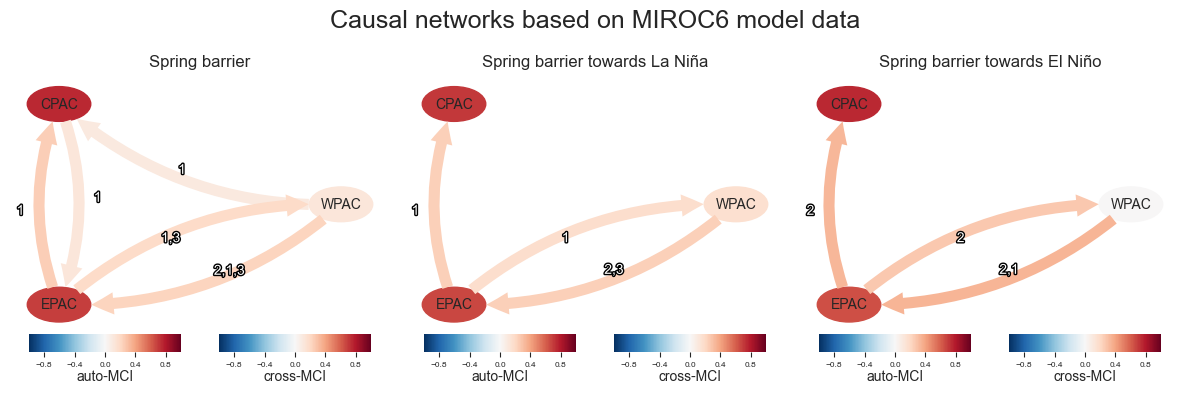

F1 score springbarrier model MIROC6:  0.6923076923076924
F1 score nina model MIROC6:  0.5333333333333333
F1 score nino model MIROC6:  0.5


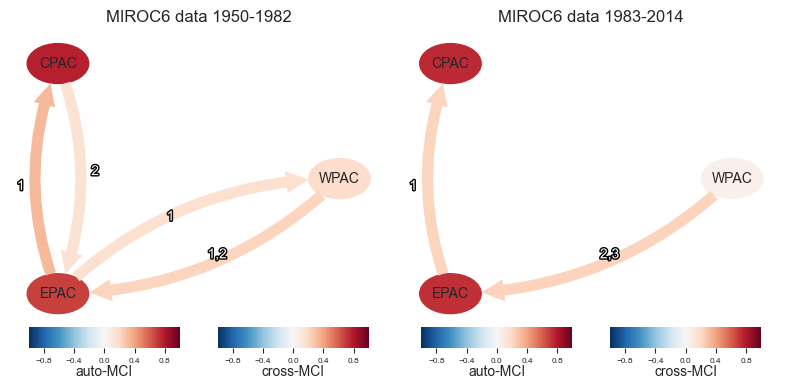

Number of nino years before 1985:  10
Number of nina years before 1985:  19
Number of neutral years before 1985:  3
Number of significant links based on data before 1985: 8
Mean strength of significant links based on data before 1985: 0.3376957437141724
Number of nino years after 1985:  4
Number of nina years after 1985:  21
Number of neutral years after 1985:  7
Number of significant links based on data after 1985: 6
Mean strength of significant links based on data after 1985: 0.4007418273196492


({'graph': array([[['', '', '-->', ''],
          ['', '', '', ''],
          ['', '-->', '-->', '']],
  
         [['', '', '', ''],
          ['', '-->', '', ''],
          ['', '', '-->', '']],
  
         [['', '-->', '', ''],
          ['', '-->', '', ''],
          ['', '-->', '', '']]], dtype='<U3'),
  'p_matrix': array([[[1.00000000e+00, 5.32474914e-02, 9.02977778e-03, 8.21209907e-01],
          [1.00000000e+00, 8.79499851e-02, 8.21209907e-01, 9.52012074e-01],
          [1.00000000e+00, 1.32616961e-03, 4.59639362e-03, 1.59737876e-01]],
  
         [[1.00000000e+00, 1.40063226e-01, 7.41019077e-01, 5.83258779e-02],
          [1.00000000e+00, 1.91296561e-57, 1.20086780e-01, 8.66905015e-01],
          [1.00000000e+00, 5.02319551e-01, 4.23497002e-02, 8.21209907e-01]],
  
         [[1.00000000e+00, 2.47775095e-02, 3.47500350e-01, 1.40063226e-01],
          [1.00000000e+00, 2.75219033e-07, 4.88820085e-01, 9.79878953e-01],
          [1.00000000e+00, 1.54432407e-38, 2.54335651e-01, 8.85

In [61]:
results_springbarrier_MIROC6, results_nina_MIROC6, results_nino_MIROC6 = mainfunction(MIROC6_data, nino34MIROC6, MIROC6, parcorr)
score_function(MIROC6,
                  results_springbarrier_reanalysis,
                  results_nina_reanalysis, 
                  results_nino_reanalysis,
                  results_springbarrier_MIROC6,
                  results_nina_MIROC6,
                  results_nino_MIROC6
                  )

firsthalf_lasthalf(MIROC6_data, nino34MIROC6, MIROC6, parcorr)


# Reanalysis extended

Reanalysis extended results
p-value PhillipsPerron test cpac: 2.1997765168193367e-07
p-value PhillipsPerron test epac: 6.928981097927765e-08
p-value PhillipsPerron test wpac: 0.0
p-value Shapiro-Wilk test cpac: 0.028344880789518356
p-value Shapiro-Wilk test epac: 9.481604755247873e-17
p-value Shapiro-Wilk test wpac: 8.321854316761801e-09
Number of nino years Reanalysis extended:  15
Number of nina years Reanalysis extended:  32
Number of neutral years Reanalysis extended:  25


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

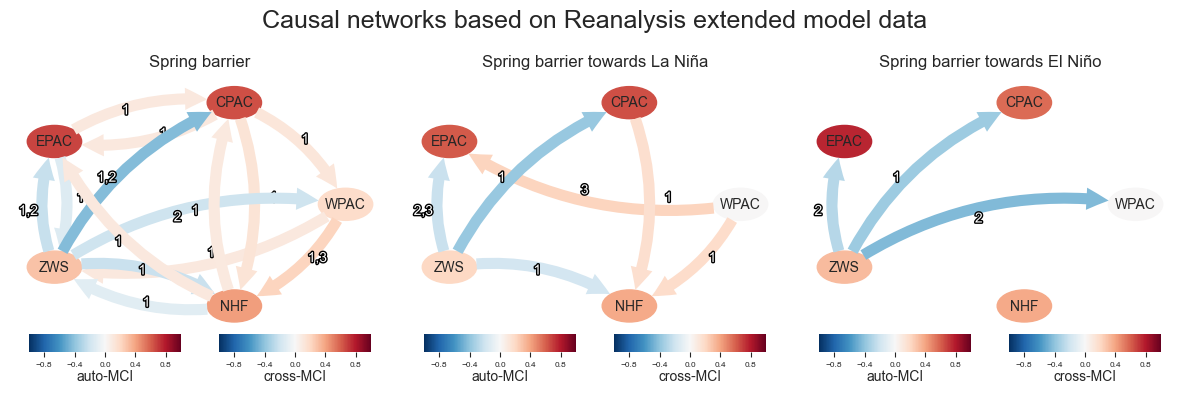

In [62]:
results_springbarrier_extended, results_nina_extended, results_nino_extended = mainfunction(extended_data, 
                                                                                            nino34reanalysis, 
                                                                                            reanalysis_extended, 
                                                                                            parcorr, 
                                                                                            extended = True)


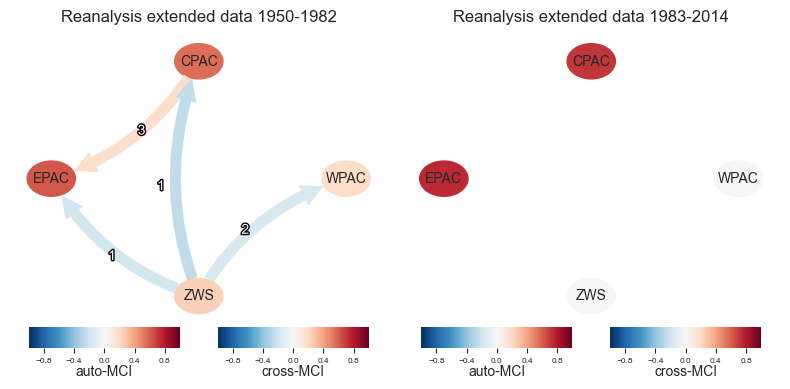

Number of nino years before 1985:  9
Number of nina years before 1985:  14
Number of neutral years before 1985:  9
Number of significant links based on data before 1985: 9
Mean strength of significant links based on data before 1985: 0.28610870800638005
Number of nino years after 1985:  5
Number of nina years after 1985:  14
Number of neutral years after 1985:  13
Number of significant links based on data after 1985: 12
Mean strength of significant links based on data after 1985: 0.33990511658864614


({'graph': array([[['', '-->', '', ''],
          ['', '', '', ''],
          ['', '', '', ''],
          ['', '', '', '']],
  
         [['', '', '', ''],
          ['', '-->', '', ''],
          ['', '', '', '-->'],
          ['', '', '', '']],
  
         [['', '', '', ''],
          ['', '', '', ''],
          ['', '-->', '', ''],
          ['', '', '', '']],
  
         [['', '', '-->', ''],
          ['', '-->', '', ''],
          ['', '-->', '', ''],
          ['', '-->', '-->', '']]], dtype='<U3'),
  'p_matrix': array([[[1.00000000e+00, 1.02064192e-02, 6.46298675e-01, 8.67260526e-01],
          [1.00000000e+00, 5.48157476e-01, 4.99093897e-01, 6.20668528e-01],
          [1.00000000e+00, 9.80473124e-01, 3.43254825e-01, 9.84280493e-01],
          [1.00000000e+00, 3.33524689e-01, 9.84280493e-01, 3.43254825e-01]],
  
         [[1.00000000e+00, 6.05325668e-02, 9.80473124e-01, 3.17499104e-01],
          [1.00000000e+00, 4.75152107e-23, 5.84903888e-01, 6.20668528e-01],
          [1.000

In [63]:
firsthalf_lasthalf(extended_data, nino34reanalysis, reanalysis_extended, parcorr, extended = True)

# Second try example graph

In [64]:
def examplefunction(GFDL_data, print_name, parcorr):

    # Variable names used throughout
    var_names = ['RF', 'SLPE', 'SLPW', 'ZWS']

    # make data frame of data
    df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
    dataframe_GFDL = pp.DataFrame(GFDL_data, 
                             datatime = np.arange(len(GFDL_data)), 
                             var_names=var_names)

    rf_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['RF'], show_plot = False)
    cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['SLPW'], show_plot = False)
    epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['ZWS'], show_plot = False)
    wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['SLPE'], show_plot = False)

    df_GFDL_processed = pd.DataFrame({'RF': rf_detrend_GFDL, 'SLPE': wpac_detrend_GFDL, 'SLPW': cpac_detrend_GFDL, 'ZWS': epac_detrend_GFDL})
        
    parcorr = ParCorr(significance='analytic')
            
    dataframe_GFDL = pp.DataFrame(np.copy(df_GFDL_processed), datatime = {0:np.arange(len(df_GFDL_processed))}, var_names= var_names)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=8)
    results_springbarrier = pcmci_GFDL.run_pcmci(tau_max=1, tau_min=1, pc_alpha=0.01, alpha_level=0.01, fdr_method = 'fdr_bh')

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

    tp.plot_graph(
            val_matrix=results_springbarrier['val_matrix'],
            graph=results_springbarrier['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0]))
    axes[0].set_title('Example graph')
        
    tp.plot_time_series_graph(
            val_matrix=results_springbarrier['val_matrix'],
            graph=results_springbarrier['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            fig_ax= (fig, axes[1]))
    axes[1].set_title('Example time series graph')
        
    plt.show()
        
    return results_springbarrier
   
    

In [65]:
# Variable names used throughout
var_names = ['RF', 'SLPE', 'SLPW', 'ZWS']

# make data frame of data
df_VAR_example = pd.DataFrame(example2_data, columns=var_names)   

rf_detrend_VAR = deTrend_deSeasonalize(df_VAR_example['RF'], show_plot = False)
cpac_detrend_VAR = deTrend_deSeasonalize(df_VAR_example['SLPE'], show_plot = False)
wpac_detrend_VAR = deTrend_deSeasonalize(df_VAR_example['SLPW'], show_plot = False)
zws_detrend_VAR = deTrend_deSeasonalize(df_VAR_example['ZWS'], show_plot = False)

df_VAR_processed_example = pd.DataFrame({'RF': rf_detrend_VAR, 'SLPE': wpac_detrend_VAR, 'SLPW': cpac_detrend_VAR, 'ZWS': zws_detrend_VAR})

df_VAR_processed_example_lagged = df_VAR_processed_example.shift(1)
df_VAR_processed_example_lagged2 = df_VAR_processed_example.shift(2)

df_VAR_processed_example = df_VAR_processed_example.iloc[2:]
df_VAR_processed_example_lagged = (df_VAR_processed_example_lagged.dropna()).iloc[1:]
df_VAR_processed_example_lagged2 = df_VAR_processed_example_lagged2.dropna()

zws1 = df_VAR_processed_example_lagged['ZWS']
slpe1 = df_VAR_processed_example_lagged['SLPE']
rf1 = df_VAR_processed_example_lagged['RF']
zws2 = df_VAR_processed_example_lagged2['ZWS']
rf2 = df_VAR_processed_example_lagged2['RF']


# Define the dependent variable
Y = df_VAR_processed_example['SLPE']

Xpc = pd.concat([zws1, slpe1, rf1], axis=1)

# Fit the model
model = sm.OLS(Y, Xpc)
results = model.fit()

print(results.summary())

# Define the independent variables
Xmci = pd.concat([zws1, slpe1, rf1, zws2, rf2], axis=1)

# Fit the model
model = sm.OLS(Y, Xmci)
results = model.fit()

print(results.summary())




                                 OLS Regression Results                                
Dep. Variable:                   SLPE   R-squared (uncentered):                   0.395
Model:                            OLS   Adj. R-squared (uncentered):              0.393
Method:                 Least Squares   F-statistic:                              187.0
Date:                Thu, 09 Nov 2023   Prob (F-statistic):                    2.56e-93
Time:                        14:56:51   Log-Likelihood:                         -4730.6
No. Observations:                 862   AIC:                                      9467.
Df Residuals:                     859   BIC:                                      9482.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [66]:
# Define the dependent variable
Y = df_VAR_processed_example['SLPE']

# Define the independent variables
Xpc = df_VAR_processed_example_lagged[['SLPW']]

# Fit the model
model = sm.OLS(Y, Xpc)
results = model.fit()

print(results.summary())

# Define the dependent variable
Y = df_VAR_processed_example['SLPE']

# Define the independent variables
Xpc2 = df_VAR_processed_example_lagged[['SLPW', 'ZWS']]

# Fit the model
model = sm.OLS(Y, Xpc2)
results = model.fit()

print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:                   SLPE   R-squared (uncentered):                   0.233
Model:                            OLS   Adj. R-squared (uncentered):              0.232
Method:                 Least Squares   F-statistic:                              261.6
Date:                Thu, 09 Nov 2023   Prob (F-statistic):                    1.41e-51
Time:                        14:56:55   Log-Likelihood:                         -4832.9
No. Observations:                 862   AIC:                                      9668.
Df Residuals:                     861   BIC:                                      9673.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 1
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Variable RF

Iterating through pc_alpha = [0.01]:

# pc_alpha = 0.01 (1/1):

Testing condition sets of dimension 0:

    Link (RF -1) -?> RF (1/4):
    Subset 0: () gives pval = 0.00000 / val =  0.679
    No conditions of dimension 0 left.

    Link (SLPE -1) -?> RF (2/4):
    Subset 0: () gives pval = 0.00000 / val =  0.564
    No conditions of dimension 0 left.

    Link (SLPW -1) -?> RF (3/4):
    Subset 0: () gives pval = 0.00000 / val = -0.519
    No conditions of dimension 0 left.

    Link (ZWS -1) -?> RF (4/4):
    Subset 0: () gives pval = 0.00000 / val = -0.596
    No conditions of dimension 0 left.

    Sorting parents in decreasing order with 
    weight(i-tau->j) = min_{iterations} |val_{ij}(tau)| 

Updating parents:

    Variable RF has 4 link(s):
        (RF -1): max_pval = 0.00

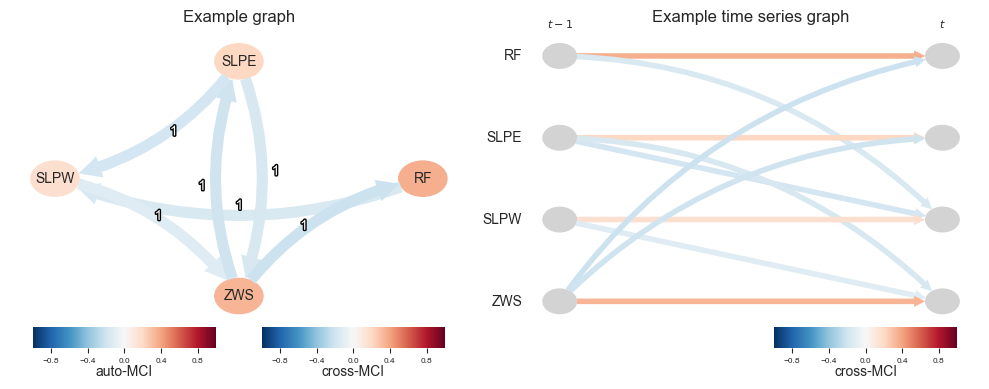

{'graph': array([[['', '-->'],
         ['', ''],
         ['', '-->'],
         ['', '']],
 
        [['', ''],
         ['', '-->'],
         ['', '-->'],
         ['', '-->']],
 
        [['', ''],
         ['', ''],
         ['', '-->'],
         ['', '-->']],
 
        [['', '-->'],
         ['', '-->'],
         ['', ''],
         ['', '-->']]], dtype='<U3'),
 'p_matrix': array([[[1.00000000e+00, 4.94349282e-27],
         [1.00000000e+00, 7.67039572e-01],
         [1.00000000e+00, 4.27922646e-06],
         [1.00000000e+00, 6.71740820e-01]],
 
        [[1.00000000e+00, 7.78218254e-01],
         [1.00000000e+00, 2.78248133e-09],
         [1.00000000e+00, 2.10522668e-07],
         [1.00000000e+00, 2.30258845e-06]],
 
        [[1.00000000e+00, 4.69617146e-02],
         [1.00000000e+00, 2.80510496e-01],
         [1.00000000e+00, 2.30258845e-06],
         [1.00000000e+00, 6.82693189e-04]],
 
        [[1.00000000e+00, 6.22870581e-10],
         [1.00000000e+00, 2.78248133e-09],
         

In [67]:
examplefunction(example2_data, example2, parcorr)

# Plots for in thesis

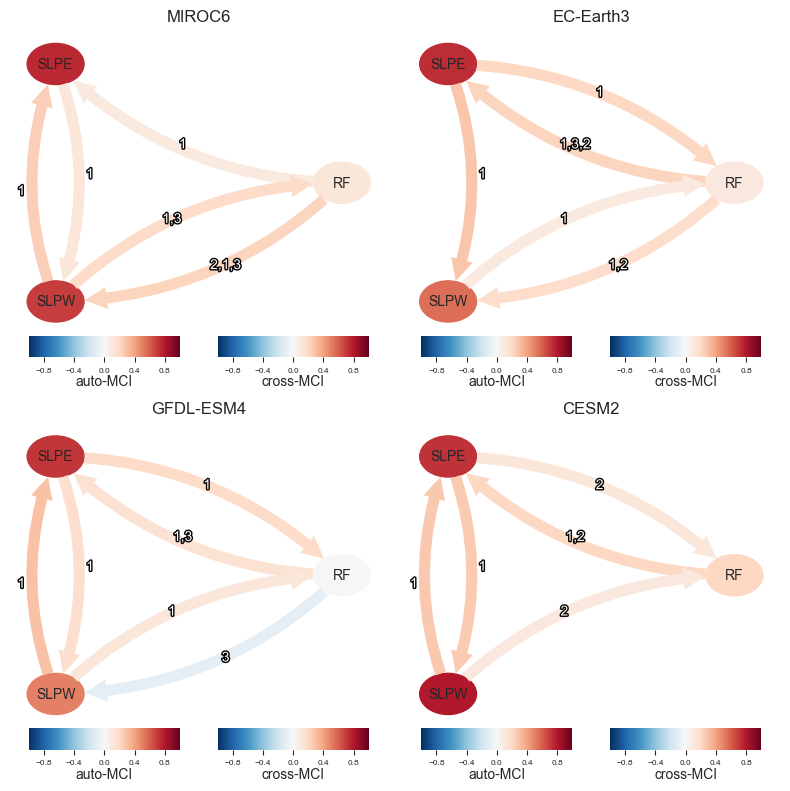

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)

tp.plot_graph(
        val_matrix=results_springbarrier_MIROC6['val_matrix'],
        graph=results_springbarrier_MIROC6['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        fig_ax= (fig, axes[0,0]))
axes[0,0].set_title('MIROC6')

tp.plot_graph(
        val_matrix=results_springbarrier_ecearth['val_matrix'],
        graph=results_springbarrier_ecearth['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        fig_ax= (fig, axes[0,1]))
axes[0,1].set_title('EC-Earth3')

tp.plot_graph(
        val_matrix=results_springbarrier_GFDL['val_matrix'],
        graph=results_springbarrier_GFDL['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        fig_ax= (fig, axes[1,0]))
axes[1,0].set_title('GFDL-ESM4')

tp.plot_graph(
        val_matrix=results_springbarrier_CESM2['val_matrix'],
        graph=results_springbarrier_CESM2['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        fig_ax= (fig, axes[1,1]))
axes[1,1].set_title('CESM2')
    

#plt.savefig('/Users/hp/Documents/Econometrics; Climate Economics/Scriptie/Figures/graphs_models_alldata.png')    
#plt.subplots_adjust(hspace=0.8)

plt.show()

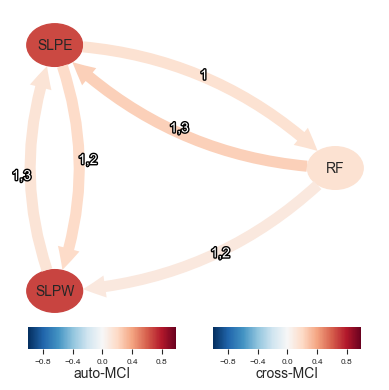

In [75]:
fig, ax = plt.subplots(figsize=(4, 4), tight_layout=True)

tp.plot_graph(
    val_matrix=results_springbarrier_reanalysis['val_matrix'],
    graph=results_springbarrier_reanalysis['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax=(fig, ax))
ax.set_title('')

#plt.savefig('/Users/hp/Documents/Econometrics; Climate Economics/Scriptie/Figures/graph_reanalysis_alldata.png')
plt.show()

# Estimate VAR

In [76]:
# Variable names used throughout
var_names = ['WPAC', 'CPAC', 'EPAC']

# make data frame of data
df_VAR = pd.DataFrame(reanalysis_data, columns=var_names)

cpac_detrend_VAR = deTrend_deSeasonalize(df_VAR['CPAC'], show_plot = False)
epac_detrend_VAR = deTrend_deSeasonalize(df_VAR['EPAC'], show_plot = False)
wpac_detrend_VAR = deTrend_deSeasonalize(df_VAR['WPAC'], show_plot = False)

df_VAR_processed = pd.DataFrame({'WPAC': wpac_detrend_VAR, 'CPAC': cpac_detrend_VAR, 'EPAC': epac_detrend_VAR})

In [77]:
model = sm.tsa.VAR(df_VAR_processed)

results = model.fit(3)

print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Nov, 2023
Time:                     14:58:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.13645
Nobs:                     861.000    HQIC:                   3.03412
Log likelihood:          -4913.99    FPE:                    19.5048
AIC:                      2.97066    Det(Omega_mle):         18.8407
--------------------------------------------------------------------
Results for equation WPAC
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.078820         1.895898           -0.042           0.967
L1.WPAC         0.165859         0.034465            4.812           0.000
L1.CPAC        31.538836         7.350935            4.290           0.000
L1.EPAC   

Reanalysis results
p-value PhillipsPerron test cpac: 2.1997765168193367e-07
p-value PhillipsPerron test epac: 6.928981097927765e-08
p-value PhillipsPerron test wpac: 0.0
p-value Shapiro-Wilk test cpac: 0.028344880789518356
p-value Shapiro-Wilk test epac: 9.481604755247873e-17
p-value Shapiro-Wilk test wpac: 8.321854316761801e-09
Number of nino years Reanalysis:  15
Number of nina years Reanalysis:  32
Number of neutral years Reanalysis:  25


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

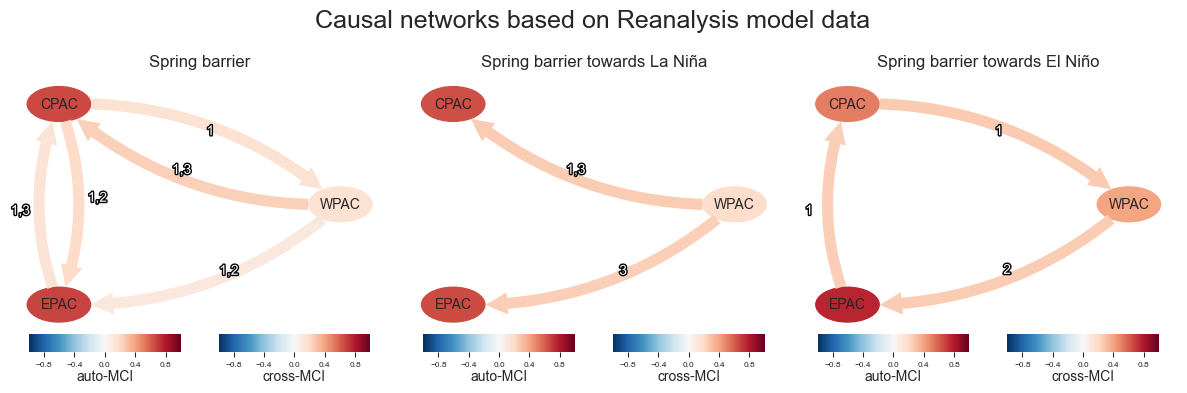

3
[[[ 0.          0.15220762  0.1236868  -0.0158684 ]
  [ 0.          0.24158217 -0.07652976 -0.0932129 ]
  [ 0.          0.10312748  0.08852187  0.08104592]]

 [[ 0.          0.15231495  0.00446808  0.03863066]
  [ 0.          0.65906452  0.00108483  0.03129031]
  [ 0.          0.19118245 -0.13074115 -0.00784662]]

 [[ 0.          0.04302619  0.04675591  0.04193338]
  [ 0.          0.1359329   0.00687954 -0.11671388]
  [ 0.          0.67634815  0.01424508 -0.09731613]]]


In [78]:
resultspring, resultnino, resultnina = mainfunction(reanalysis_data, nino34reanalysis, reanalysis, parcorr)
p_matrices = resultspring['p_matrix']
val_matrices = resultspring['val_matrix']

print(p_matrices.shape[1])
print(val_matrices)

In [79]:
def compute_mean_correlations(p_matrices, val_matrices):
    num_matrices = p_matrices.shape[0]
    sum_significant_values = 0
    count_significant_values = 0

    for i in range(num_matrices):
        p_matrix = p_matrices[i]
        val_matrix = val_matrices[i]
    
        rows = p_matrices[i].shape[0]
        columns = p_matrices[i].shape[1]
        # Skip the first column in each matrix
    
        for j in range(rows):
            for k in range(1, columns):
                if p_matrix[j,k] < 0.05:
                    sum_significant_values += val_matrix[j,k]
                    count_significant_values += 1
    
        if count_significant_values > 0:
            mean_significant_values = sum_significant_values / count_significant_values
        else:
            mean_significant_values = 0

    return mean_significant_values, count_significant_values



In [80]:
compute_mean_correlations(p_matrices, val_matrices)

(0.14899891805701398, 14)

# NICE MASKING PLOTS

In [81]:
extended_data[:,:1]

# Variable names used throughout
var_name = ['WPAC', 'CPAC']
wpac_data = extended_data[:,:2]

# make data frame of data
df_wpac = pd.DataFrame(wpac_data, columns=var_name)

wpac_detrend = deTrend_deSeasonalize(df_wpac['WPAC'], show_plot = False)
cpac_detrend = deTrend_deSeasonalize(df_wpac['CPAC'], show_plot = False)

df_wpac_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend})

print(df_wpac_processed)



           WPAC      CPAC
0    -78.690357 -0.613648
1   -129.759444 -0.698600
2    -69.900195 -0.349118
3   -150.179920 -0.534241
4    -86.328137 -0.440909
..          ...       ...
859   67.966240 -0.478347
860  -26.789694 -0.206191
861  -13.961407 -0.827378
862  -31.834931 -0.891198
863  -31.992068 -0.756757

[864 rows x 2 columns]


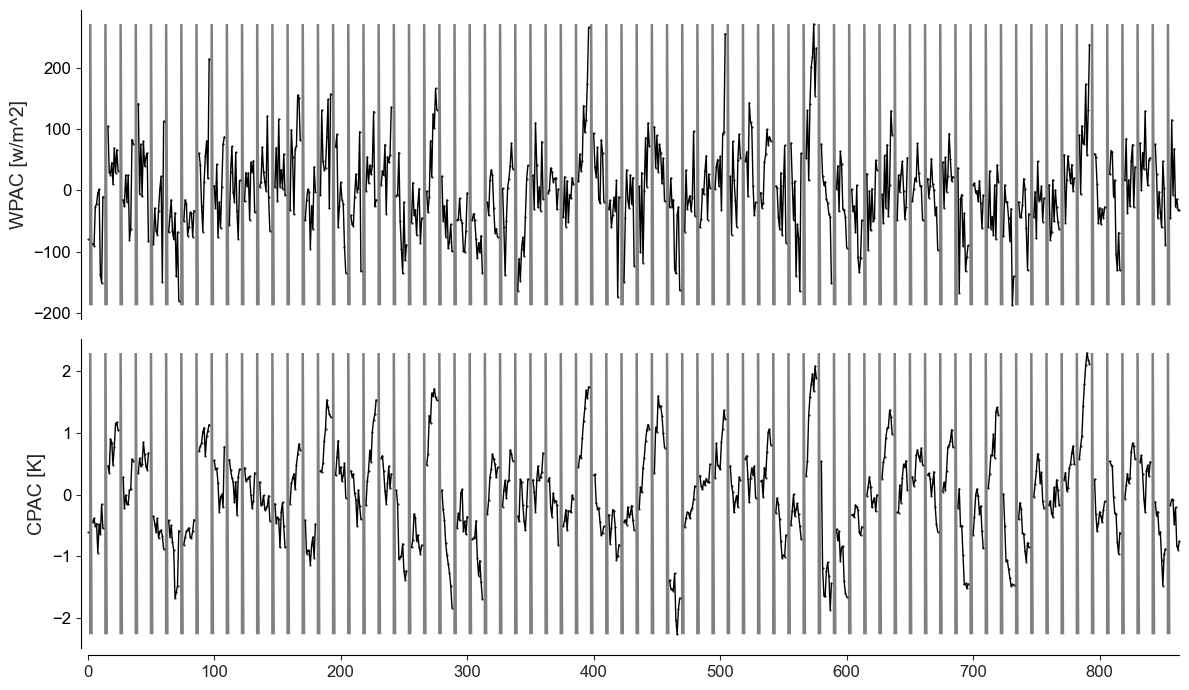

In [82]:
ninomask_GFDL, ninamask_GFDL, neutralmask_GFDL = mask_maker(nino34reanalysis)

# Construct mask for spring barrier
cycle_length = 12
springbarrier_mask = np.ones(df_wpac_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False
    
dataframe_GFDL = pp.DataFrame(np.copy(df_wpac_processed), datatime = {0:np.arange(len(df_wpac_processed))}, var_names= var_name, mask = springbarrier_mask)

tp.plot_timeseries(dataframe_GFDL, figsize=(12,7), grey_masked_samples='fill', var_units=['w/m^2','K'], label_fontsize = 14, tick_label_size = 12)
plt.show()


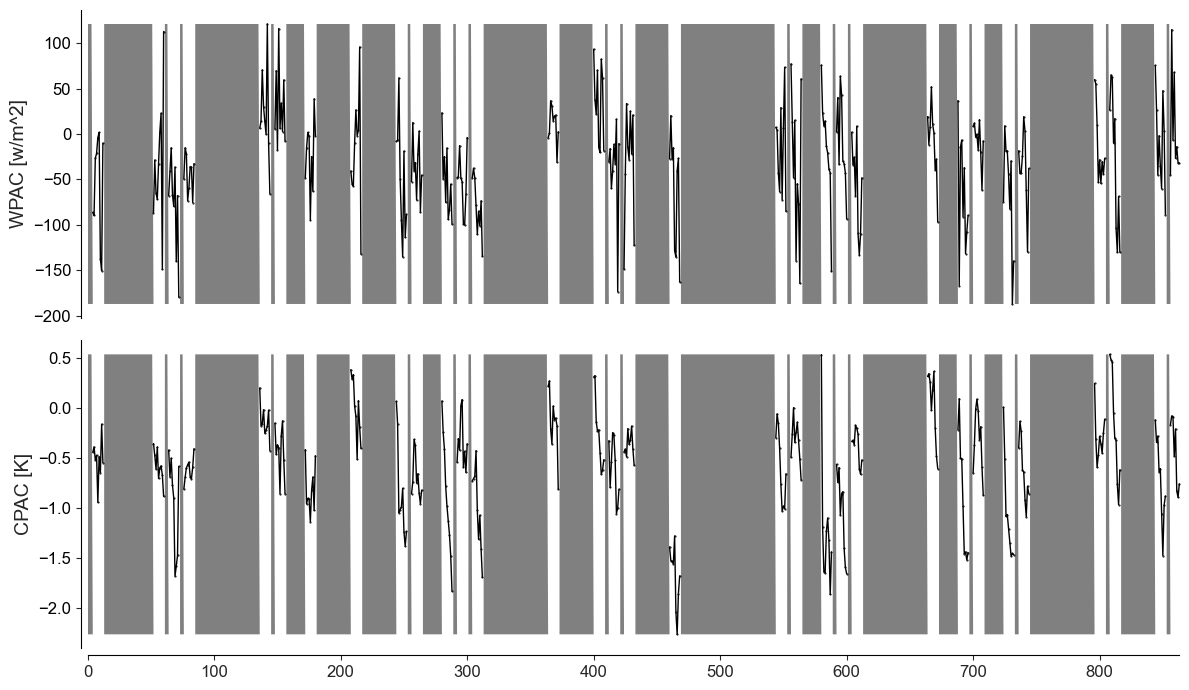

In [83]:
# Construct mask for spring barrier
cycle_length = 12
nina_spring_GFDL = np.ones(df_wpac_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    nina_spring_GFDL[i::cycle_length, :] = False
    
# Additionally mask to pick only La Nina phases in spring barrier
for t in range(nina_spring_GFDL.shape[0]):
    if ninamask_GFDL[t] == True:
        nina_spring_GFDL[t] = True
        
dataframe_GFDL = pp.DataFrame(np.copy(df_wpac_processed), datatime = {0:np.arange(len(df_wpac_processed))}, var_names= var_name, mask = nina_spring_GFDL)

tp.plot_timeseries(dataframe_GFDL, figsize=(12,7), grey_masked_samples='fill',var_units=['w/m^2','K'], label_fontsize = 14, tick_label_size = 12)
plt.show()
    
    

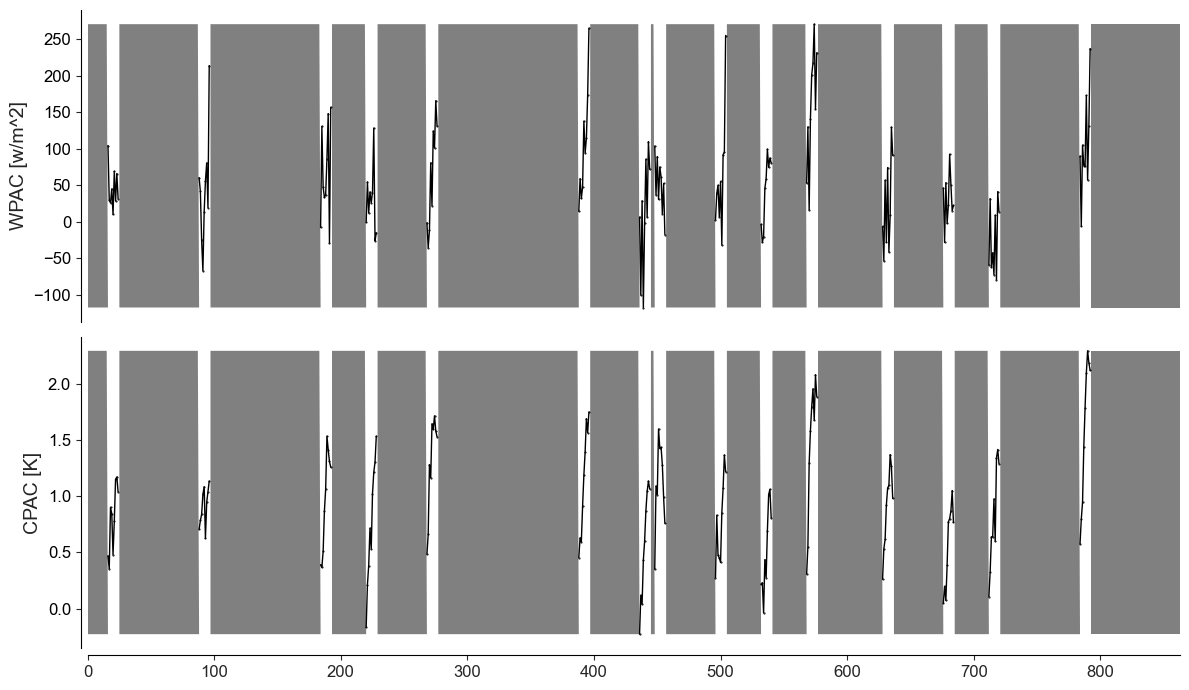

In [84]:
# Construct mask for spring barrier
cycle_length = 12
nino_spring_GFDL = np.ones(df_wpac_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    nino_spring_GFDL[i::cycle_length, :] = False
    
# Additionally mask to pick only El Nino years 
for t in range(nino_spring_GFDL.shape[0]):
    if ninomask_GFDL[t] == True:
        nino_spring_GFDL[t] = True
        
dataframe_GFDL = pp.DataFrame(np.copy(df_wpac_processed), datatime = {0:np.arange(len(df_wpac_processed))}, var_names= var_name, mask = nino_spring_GFDL)

tp.plot_timeseries(dataframe_GFDL, figsize=(12,7), grey_masked_samples='fill',var_units=['w/m^2','K'], label_fontsize = 14, tick_label_size = 12)
plt.show()

# STEPS FOR SEASONAL DECOMPOSITION

In [85]:
seasonal_wpac = seasonal_decompose(df_extended['WPAC'],  model='additive', period=12)


# NORMALITY TESTS + STATIONARITYTESTS

In [86]:
def test_norm_stat(GFDL_data, extended = 0):
    if extended == 0:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC']
        GFDL_data = GFDL_data[:,:3]

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)

        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 'CPAC': cpac_detrend_GFDL, 'EPAC': epac_detrend_GFDL})
        
        print('p-value PhillipsPerron test cpac:', PhillipsPerron(cpac_detrend_GFDL).pvalue)
        print('p-value PhillipsPerron test epac:', PhillipsPerron(epac_detrend_GFDL).pvalue)
        print('p-value PhillipsPerron test wpac:', PhillipsPerron(wpac_detrend_GFDL).pvalue)
        
        print('p-value Shapiro-Wilk test cpac:', stats.shapiro(cpac_detrend_GFDL).pvalue)
        print('p-value Shapiro-Wilk test epac:', stats.shapiro(epac_detrend_GFDL).pvalue)
        print('p-value Shapiro-Wilk test wpac:', stats.shapiro(wpac_detrend_GFDL).pvalue)
        
        
    elif extended == 1:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']
        GFDL_data = GFDL_data[:,:4]

        
        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        tw_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend})
        
        print('p-value PhillipsPerron test cpac:', PhillipsPerron(cpac_detrend_GFDL).pvalue)
        print('p-value PhillipsPerron test epac:', PhillipsPerron(epac_detrend_GFDL).pvalue)
        print('p-value PhillipsPerron test wpac:', PhillipsPerron(wpac_detrend_GFDL).pvalue)
        print('p-value PhillipsPerron test tw:', PhillipsPerron(tw_detrend_GFDL).pvalue)
        
        print('p-value Shapiro-Wilk test cpac:', stats.shapiro(cpac_detrend_GFDL).pvalue)
        print('p-value Shapiro-Wilk test epac:', stats.shapiro(epac_detrend_GFDL).pvalue)
        print('p-value Shapiro-Wilk test wpac:', stats.shapiro(wpac_detrend_GFDL).pvalue)
        print('p-value Shapiro-Wilk test tw:', stats.shapiro(tw_detrend_GFDL).pvalue)
        
        #df_GFDL_processed['ZWS'] = df_GFDL_processed['ZWS']*-1
    
    elif extended == 2:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        tw_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        nhf_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['NHF'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': tw_detrend_GFDL,
                                        'NHF': nhf_detrend_GFDL})
        
        print('p-value PhillipsPerron test wpac:', PhillipsPerron(wpac_detrend_GFDL).pvalue)
        print('p-value PhillipsPerron test cpac:', PhillipsPerron(cpac_detrend_GFDL).pvalue)
        print('p-value PhillipsPerron test epac:', PhillipsPerron(epac_detrend_GFDL).pvalue)
        print('p-value PhillipsPerron test tw:', PhillipsPerron(tw_detrend_GFDL).pvalue)
        print('p-value PhillipsPerron test nhf:', PhillipsPerron(nhf_detrend_GFDL).pvalue)
        
        print('p-value Shapiro-Wilk test wpac:', stats.shapiro(wpac_detrend_GFDL).pvalue)
        print('p-value Shapiro-Wilk test cpac:', stats.shapiro(cpac_detrend_GFDL).pvalue)
        print('p-value Shapiro-Wilk test epac:', stats.shapiro(epac_detrend_GFDL).pvalue)
        print('p-value Shapiro-Wilk test tw:', stats.shapiro(tw_detrend_GFDL).pvalue)
        print('p-value Shapiro-Wilk test nhf:', stats.shapiro(nhf_detrend_GFDL).pvalue)
        
        


In [87]:
test_norm_stat(ecearth_data, extended = 0)

p-value PhillipsPerron test cpac: 1.1352321227446008e-06
p-value PhillipsPerron test epac: 3.774769575679175e-13
p-value PhillipsPerron test wpac: 0.0
p-value Shapiro-Wilk test cpac: 2.3985458028619178e-05
p-value Shapiro-Wilk test epac: 9.468096322962083e-06
p-value Shapiro-Wilk test wpac: 1.2866341592143726e-07


C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
C:\Users\esz320\AppData\Local\anaconda3\envs\tigramite_env\lib\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

# Test to see if post-satellite data shows the same change pattern

In [88]:
# function that only takes spring barrier mask

def link_robustness_postsatellite(GFDL_data, parcorr, extended = 0, info = True):
    parcorr = ParCorr(confidence='analytic', mask_type='y')
    if extended == 0:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC']
        GFDL_data = GFDL_data[:,:3]

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)

        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 'CPAC': cpac_detrend_GFDL, 'EPAC': epac_detrend_GFDL})
    
    elif extended == 1:

        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']
        GFDL_data = GFDL_data[:,:4]

        
        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend})
        
        #df_GFDL_processed['ZWS'] = df_GFDL_processed['ZWS']*-1
    
    elif extended == 2:
        # Variable names used throughout
        var_names = ['WPAC', 'CPAC', 'EPAC', 'TW', 'NHF']

        # make data frame of data
        df_GFDL = pd.DataFrame(GFDL_data, columns=var_names)
        dataframe_GFDL = pp.DataFrame(GFDL_data, 
                                 datatime = np.arange(len(GFDL_data)), 
                                 var_names=var_names)

        cpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['CPAC'], show_plot = False)
        epac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['EPAC'], show_plot = False)
        wpac_detrend_GFDL = deTrend_deSeasonalize(df_GFDL['WPAC'], show_plot = False)
        zws_detrend = deTrend_deSeasonalize(df_GFDL['TW'], show_plot = False)
        nhf_detrend = deTrend_deSeasonalize(df_GFDL['NHF'], show_plot = False)
        
        df_GFDL_processed = pd.DataFrame({'WPAC': wpac_detrend_GFDL, 
                                        'CPAC': cpac_detrend_GFDL, 
                                        'EPAC': epac_detrend_GFDL,
                                        'TW': zws_detrend,
                                        'NHF': nhf_detrend})
        
        #df_GFDL_processed['ZWS'] = df_GFDL_processed['ZWS']*-1
    
    # 1980-2002
    test1vroeg = df_GFDL_processed[360:624]
    # 1979-2001
    test2vroeg = df_GFDL_processed[348:612]
    #1981-2003
    test3vroeg = df_GFDL_processed[372:636]
    #1980-2000
    test4vroeg = df_GFDL_processed[360:600]
    #2000-2022
    test1laat = df_GFDL_processed[600:864]
    #2001-2020
    test2laat = df_GFDL_processed[612:840]
    #1999-2018
    test3laat = df_GFDL_processed[588:816]
    #2000-2020
    test4laat = df_GFDL_processed[385:840]
    
    # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test1vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test1vroeg), datatime = {0:np.arange(len(test1vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test1vroeg = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.01, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test2vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test2vroeg), datatime = {0:np.arange(len(test2vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test2vroeg = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test3vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test3vroeg), datatime = {0:np.arange(len(test3vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test3vroeg = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test4vroeg.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test4vroeg), datatime = {0:np.arange(len(test4vroeg))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test4vroeg = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test1laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test1laat), datatime = {0:np.arange(len(test1laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test1laat = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test2laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test2laat), datatime = {0:np.arange(len(test2laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test2laat = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test3laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test3laat), datatime = {0:np.arange(len(test3laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test3laat = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

        # Construct mask for spring barrier
    cycle_length = 12
    springbarrier_mask = np.ones(test4laat.shape, dtype=bool)
    for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
        springbarrier_mask[i::cycle_length, :] = False
    
    dataframe_GFDL = pp.DataFrame(np.copy(test4laat), datatime = {0:np.arange(len(test4laat))}, var_names= var_names, mask = springbarrier_mask)
    pcmci_GFDL = PCMCI(dataframe=dataframe_GFDL, cond_ind_test=parcorr,verbosity=0)
    results_test4laat = pcmci_GFDL.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
    
    if info == True:
        ## PLOT ALL DAGS

        fig, axes = plt.subplots(4, 2, figsize=(8, 16), tight_layout=True)

        tp.plot_graph(
            val_matrix=results_test1vroeg['val_matrix'],
            graph=results_test1vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0,0]))
        axes[0,0].set_title('1980-2002')

        tp.plot_graph(
            val_matrix=results_test1laat['val_matrix'],
            graph=results_test1laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[0,1]))
        axes[0,1].set_title('2000-2022')

        tp.plot_graph(
            val_matrix=results_test2vroeg['val_matrix'],
            graph=results_test2vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1,0]))
        axes[1,0].set_title('1979-2001')
        
        tp.plot_graph(
            val_matrix=results_test2laat['val_matrix'],
            graph=results_test2laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[1,1]))
        axes[1,1].set_title('2001-2020')
        
        tp.plot_graph(
            val_matrix=results_test3vroeg['val_matrix'],
            graph=results_test3vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[2,0]))
        axes[2,0].set_title('1981-2003')
        
        tp.plot_graph(
            val_matrix=results_test3laat['val_matrix'],
            graph=results_test3laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[2,1]))
        axes[2,1].set_title('1999-2018')
        
        tp.plot_graph(
            val_matrix=results_test4vroeg['val_matrix'],
            graph=results_test4vroeg['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[3,0]))
        axes[3,0].set_title('1980-2000')

        tp.plot_graph(
            val_matrix=results_test4laat['val_matrix'],
            graph=results_test4laat['graph'],
            var_names=var_names,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax= (fig, axes[3,1]))
        axes[3,1].set_title('2000-2020')

        fig.suptitle(f'Causal networks based on reanalysis data', fontsize = 18)
    
        plt.subplots_adjust(hspace=0.8)
        plt.show()

        return results_test1vroeg, results_test2vroeg, results_test3vroeg, results_test4vroeg, results_test1laat, results_test2laat, results_test3laat, results_test4laat
    

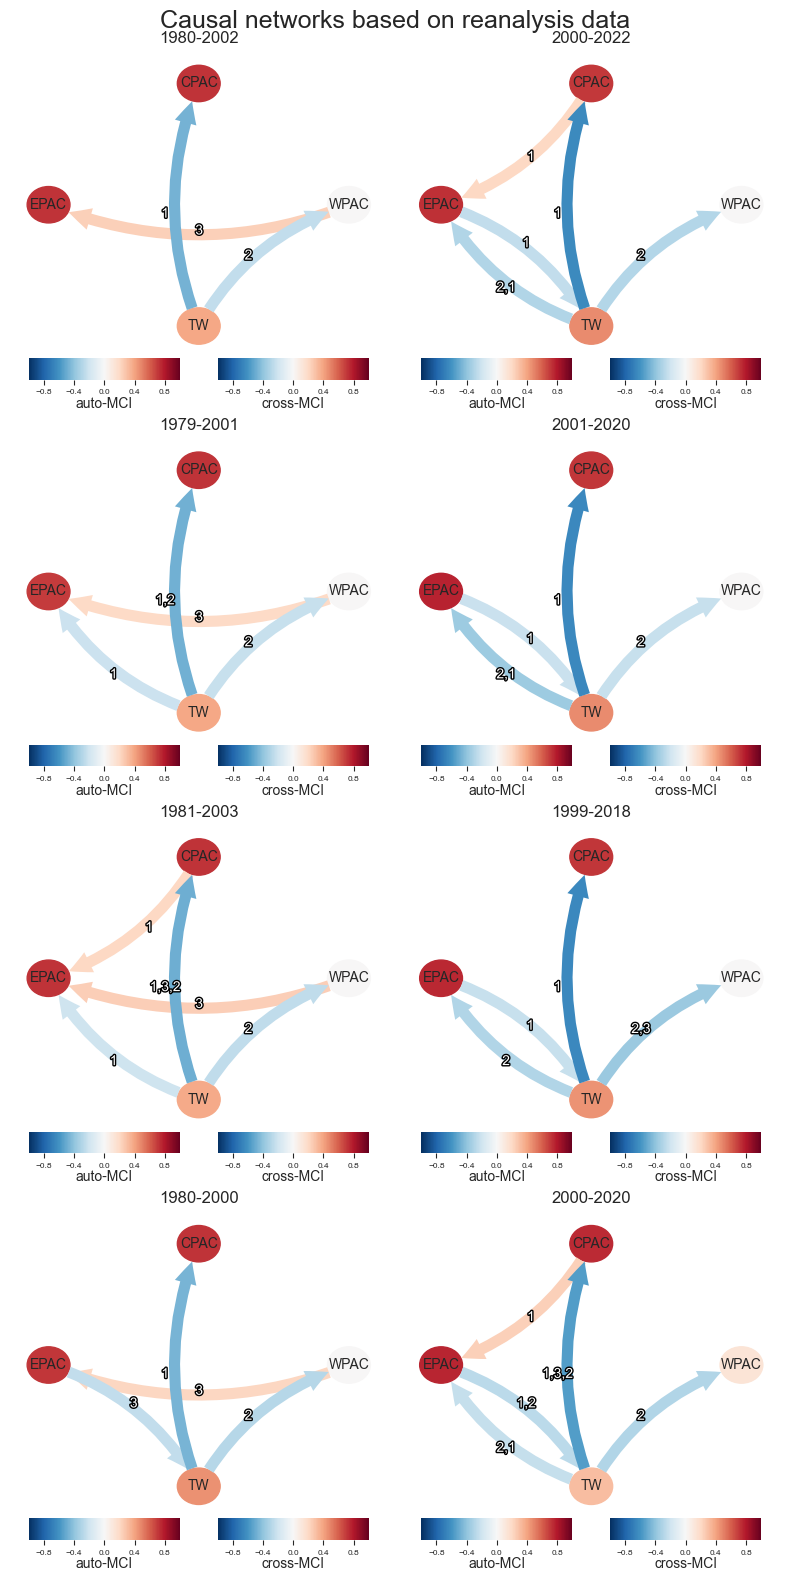

In [89]:
test1_1vroeg, test1_2vroeg, test1_3vroeg, test1_4vroeg, test1_1laat, test1_2laat, test1_3laat, test1_4laat = link_robustness_postsatellite(extended_data, parcorr, extended = 1)
var_names = ['WPAC', 'CPAC', 'EPAC', 'TW']

In [90]:
print(test1_4vroeg['val_matrix'])
print(test1_4laat['val_matrix'])

[[[ 0.          0.1627083  -0.01914032 -0.03775447]
  [ 0.          0.10596963 -0.05410249 -0.10309089]
  [ 0.          0.1000427   0.12721476  0.21134245]
  [ 0.          0.05015639 -0.09045264  0.04460478]]

 [[ 0.          0.14075865 -0.01127138  0.02138181]
  [ 0.          0.72220335 -0.00562412 -0.04886522]
  [ 0.          0.17333504 -0.11198883 -0.11878331]
  [ 0.         -0.17742858  0.05314174  0.06454926]]

 [[ 0.          0.01601636  0.03231617  0.14865725]
  [ 0.          0.15378171 -0.05340241 -0.0625028 ]
  [ 0.          0.71326588 -0.05282076 -0.02565318]
  [ 0.         -0.1535053   0.00302818 -0.24722978]]

 [[ 0.         -0.15651684 -0.28137373 -0.03149769]
  [ 0.         -0.46800104  0.178399    0.13146636]
  [ 0.         -0.16884887 -0.14788261  0.00636803]
  [ 0.          0.4557313   0.23309022  0.03695301]]]
[[[ 0.          0.13538772  0.07899985  0.02742428]
  [ 0.          0.05504363 -0.12060786 -0.07204618]
  [ 0.         -0.10161027  0.12419386  0.02807272]
  [ 